(mmm_allocation_assessment)=
# Budget Allocation Risk Assessment with PyMC-Marketing

This notebook is centered around evaluating the risks tied to different budget allocations across various marketing channels. You'll discover how to create an optimal budget allocation that aligns with your specific risk tolerance. This knowledge will empower you to make well-informed decisions regarding your budget distribution.

## Prerequisite Knowledge
The notebook assumes the reader has knowledge of the essential functionalities of PyMC-Marketing. If one is unfamiliar, the ["MMM Example Notebook"](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html) serves as an excellent starting point, offering a comprehensive introduction to media mix models in this context.

## Expected Outcomes  
Upon completion of this notebook, readers will acquire a comprehensive understanding of how to evaluate the risks associated with various budget allocations and how to develop an optimal budget allocation based on specified risk tolerance criteria.

## Preliminary Setup  
Consistent with previous notebooks in the PyMC-Marketing series, this document relies on a specific set of libraries. Below are the necessary imports required for executing the code snippets presented hereafter.

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pymc_marketing.mmm.budget_optimizer import optimizer_xarray_builder
from pymc_marketing.mmm.builders.yaml import build_mmm_from_yaml
from pymc_marketing.mmm.multidimensional import (
    MultiDimensionalBudgetOptimizerWrapper,
)
from pymc_marketing.paths import data_dir

warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/carlostrujillo/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/multidimensional.py:72: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)
/var/folders/f0/rbz8xs8s17n3k3f_ccp31bvh0000gn/T/ipykernel_31112/2722591990.py:9: UserWarning: The pymc_marketing.mmm.builders module is experimental and its API may change without warning.
  from pymc_marketing.mmm.builders.yaml import build_mmm_from_yaml


The expectation is that a model has already been trained using the functionalities provided in prior versions of the PyMC-Marketing library. Thus, the data generation and training processes will be replicated in a different notebook. Those unfamiliar with these procedures are advised to refer to the ["MMM Example Notebook."](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html)

## Loading a Pre-Trained Model
To utilize a saved model, load it into a new instance of the MMM class using the load method below.

In [2]:
data_path = data_dir / "multidimensional_mock_data.csv"
data_df = pd.read_csv(data_path, parse_dates=["date"], index_col=0)
data_df.head()

,date,y,x1,x2,event_1,event_2,dayofyear,t,geo
0,2018-04-02,3984.662237,159.290009,0.0,0.0,0.0,92,0,geo_a
1,2018-04-09,3762.871794,56.194238,0.0,0.0,0.0,99,1,geo_a
2,2018-04-16,4466.967388,146.200133,0.0,0.0,0.0,106,2,geo_a
3,2018-04-23,3864.219373,35.699276,0.0,0.0,0.0,113,3,geo_a
4,2018-04-30,4441.625278,193.372577,0.0,0.0,0.0,120,4,geo_a


In [3]:
x_train = data_df.drop(columns=["y"])
y_train = data_df["y"]

In [4]:
mmm = build_mmm_from_yaml(
    X=x_train,
    y=y_train,
    config_path=data_dir / "config_files" / "multi_dimensional_example_model.yml",
)

In [5]:
optimizable_model = MultiDimensionalBudgetOptimizerWrapper(
    model=mmm, start_date="2021-09-06", end_date="2021-11-29"
)

## Formulating the Budget Allocation Challenge  
As in earlier notebooks, it is essential to delineate the budget allocation challenge. Specifically, we must define the duration of our budget allocation and the permissible expenditure per time unit. Our model utilizes weekly data; therefore, we will maintain the same temporal granularity.

In this example, we aim to distribute a budget across two channels over the course of eight weeks, with a weekly budget of 3 Million. Consequently, the total budget available for allocation amounts to 24 Million.

In [6]:
num_periods = optimizable_model.num_periods
time_unit_budget = 3_000  # Imagine is 3K or 3M (per week in this case)

# Define your channels
channels = ["x1", "x2"]
geos = ["geo_a", "geo_b"]

print(f"Total budget to allocate: {num_periods * time_unit_budget:,.0f}")

Total budget to allocate: 39,000


Based on our intuition, we were thinking of distributing this budget into 80% Million for Google ($x2$) and 20% Million for Facebook ($x1$). Using this allocation, we can compute the response distribution and plot it.

Sampling: [y]


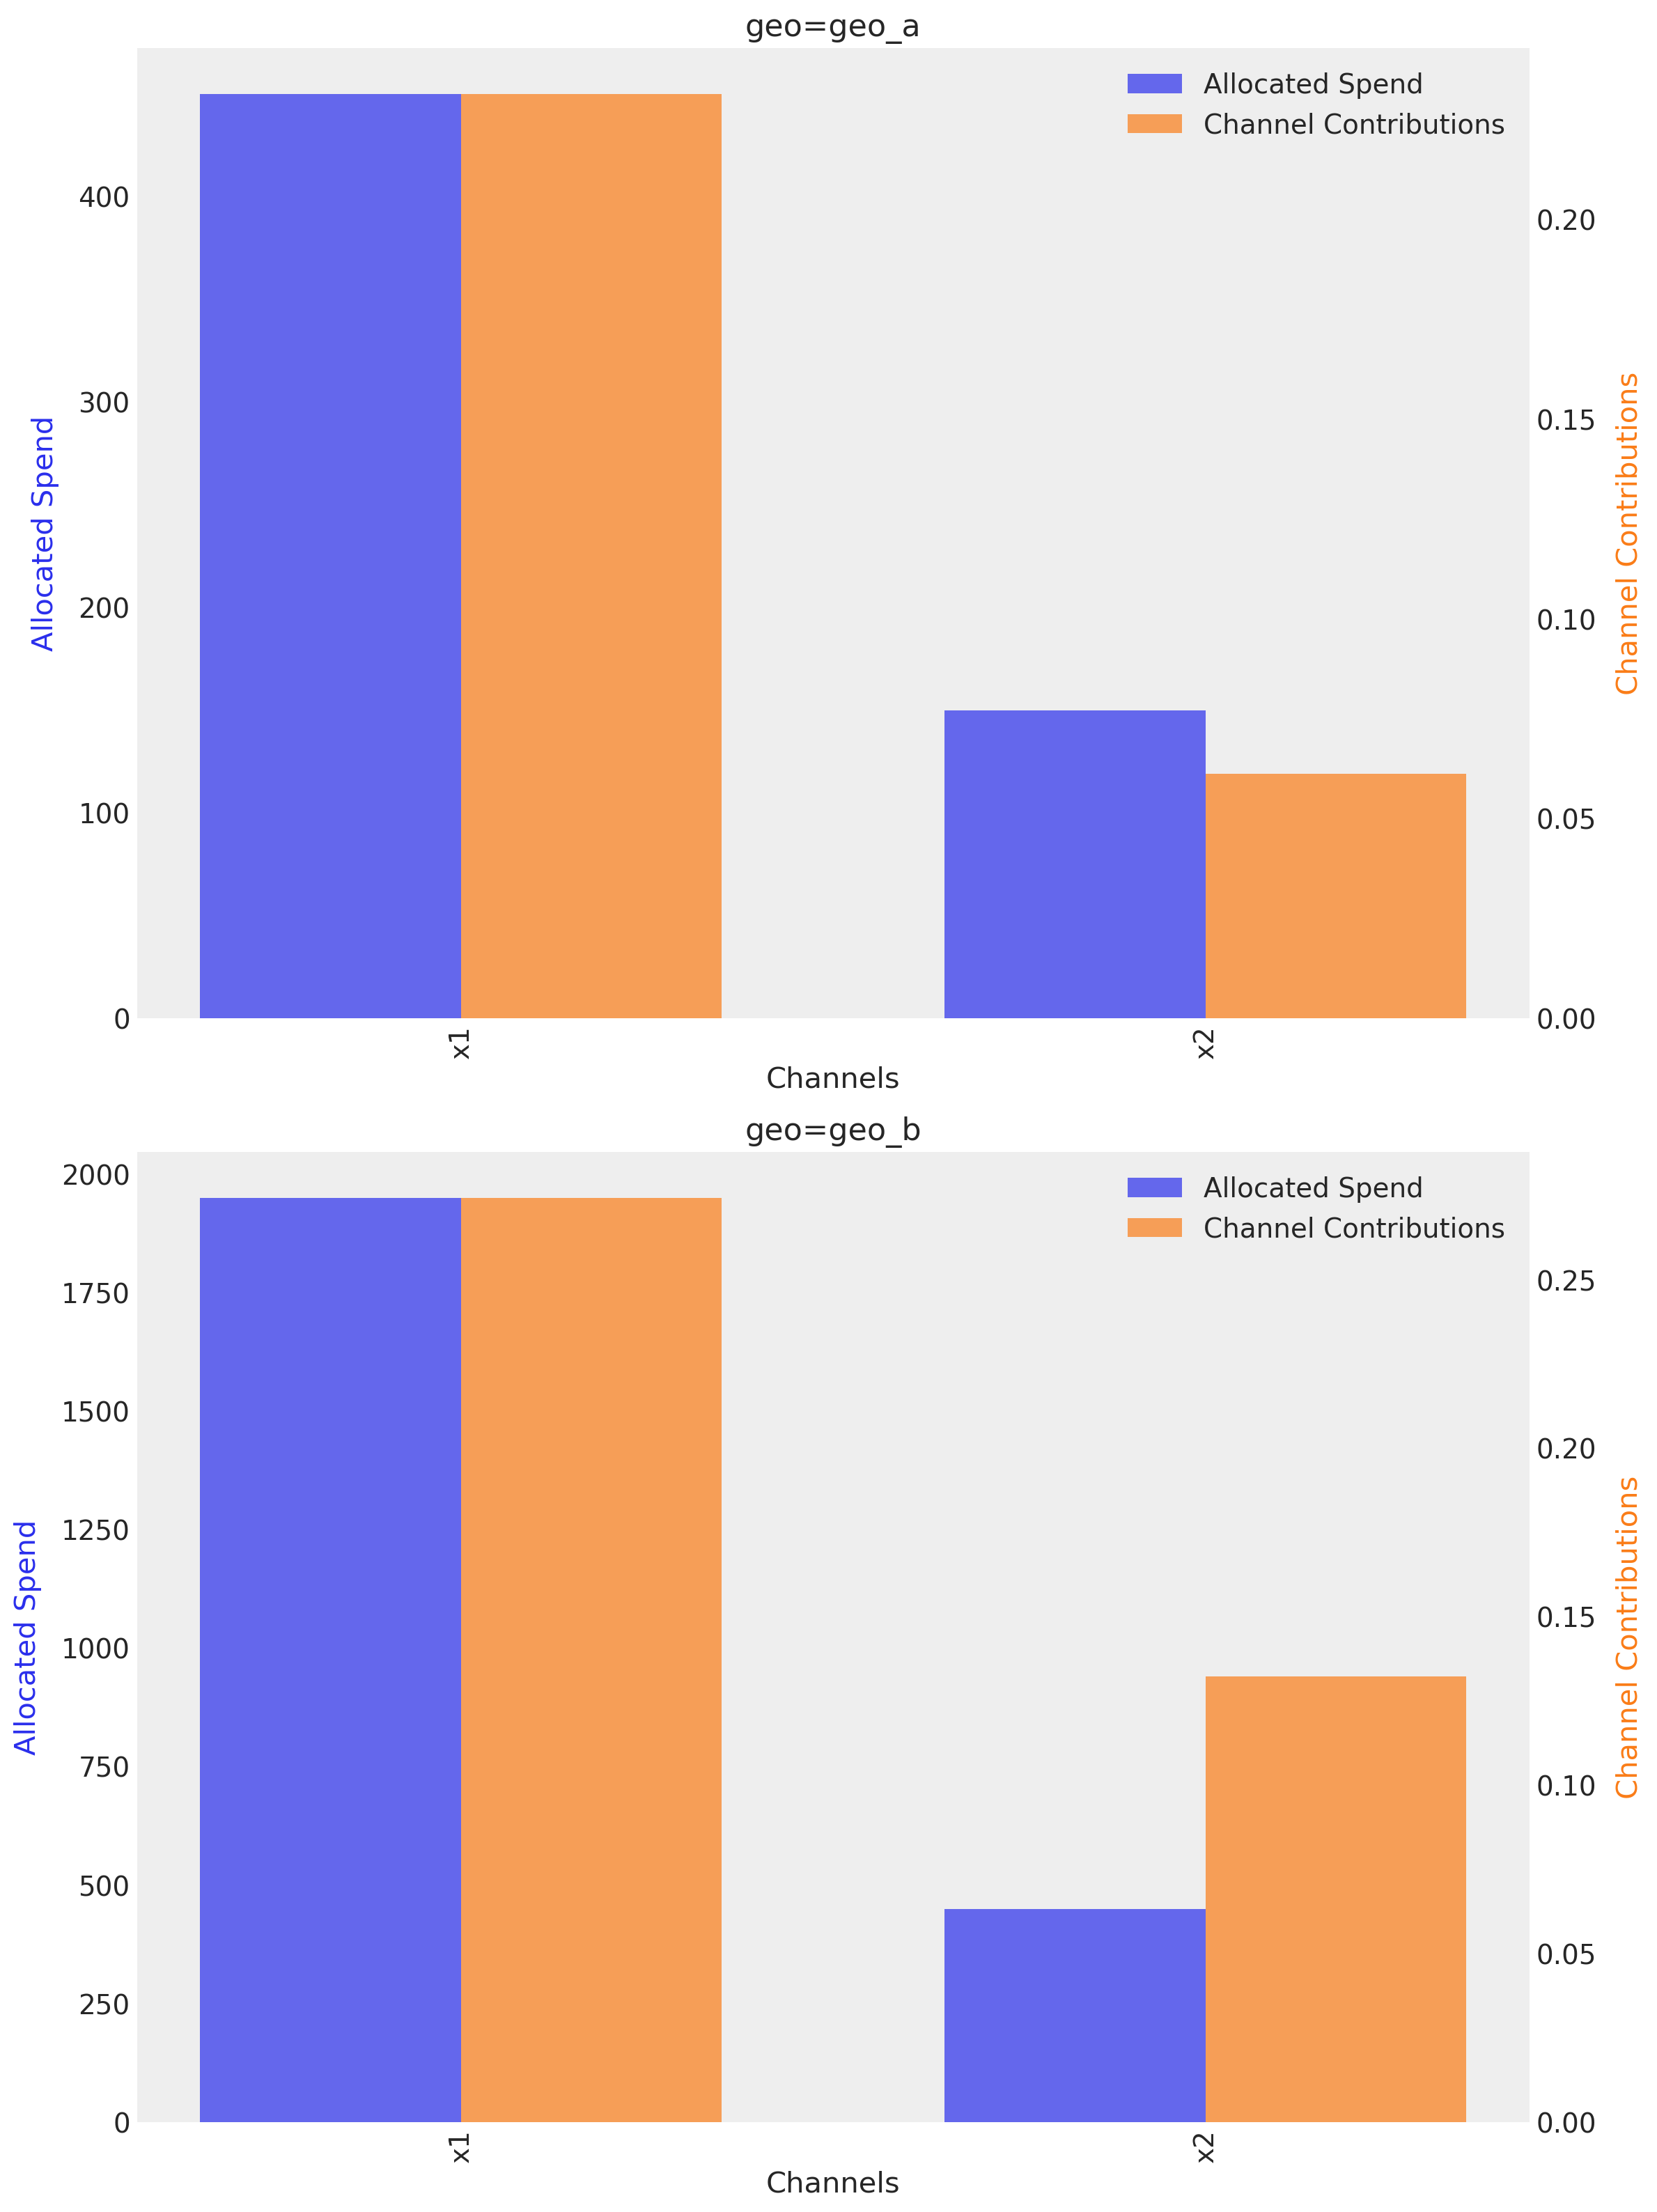

In [7]:
initial_budget = optimizer_xarray_builder(
    np.array(
        [
            [time_unit_budget * 0.15, time_unit_budget * 0.65],
            [time_unit_budget * 0.05, time_unit_budget * 0.15],
        ]
    ),
    channel=channels,
    geo=geos,
)
initial_posterior_response = optimizable_model.sample_response_distribution(
    allocation_strategy=initial_budget,
    include_carryover=True,
    include_last_observations=False,
)

fig, ax = optimizable_model.plot.budget_allocation(
    samples=initial_posterior_response, figsize=(12, 8)
)

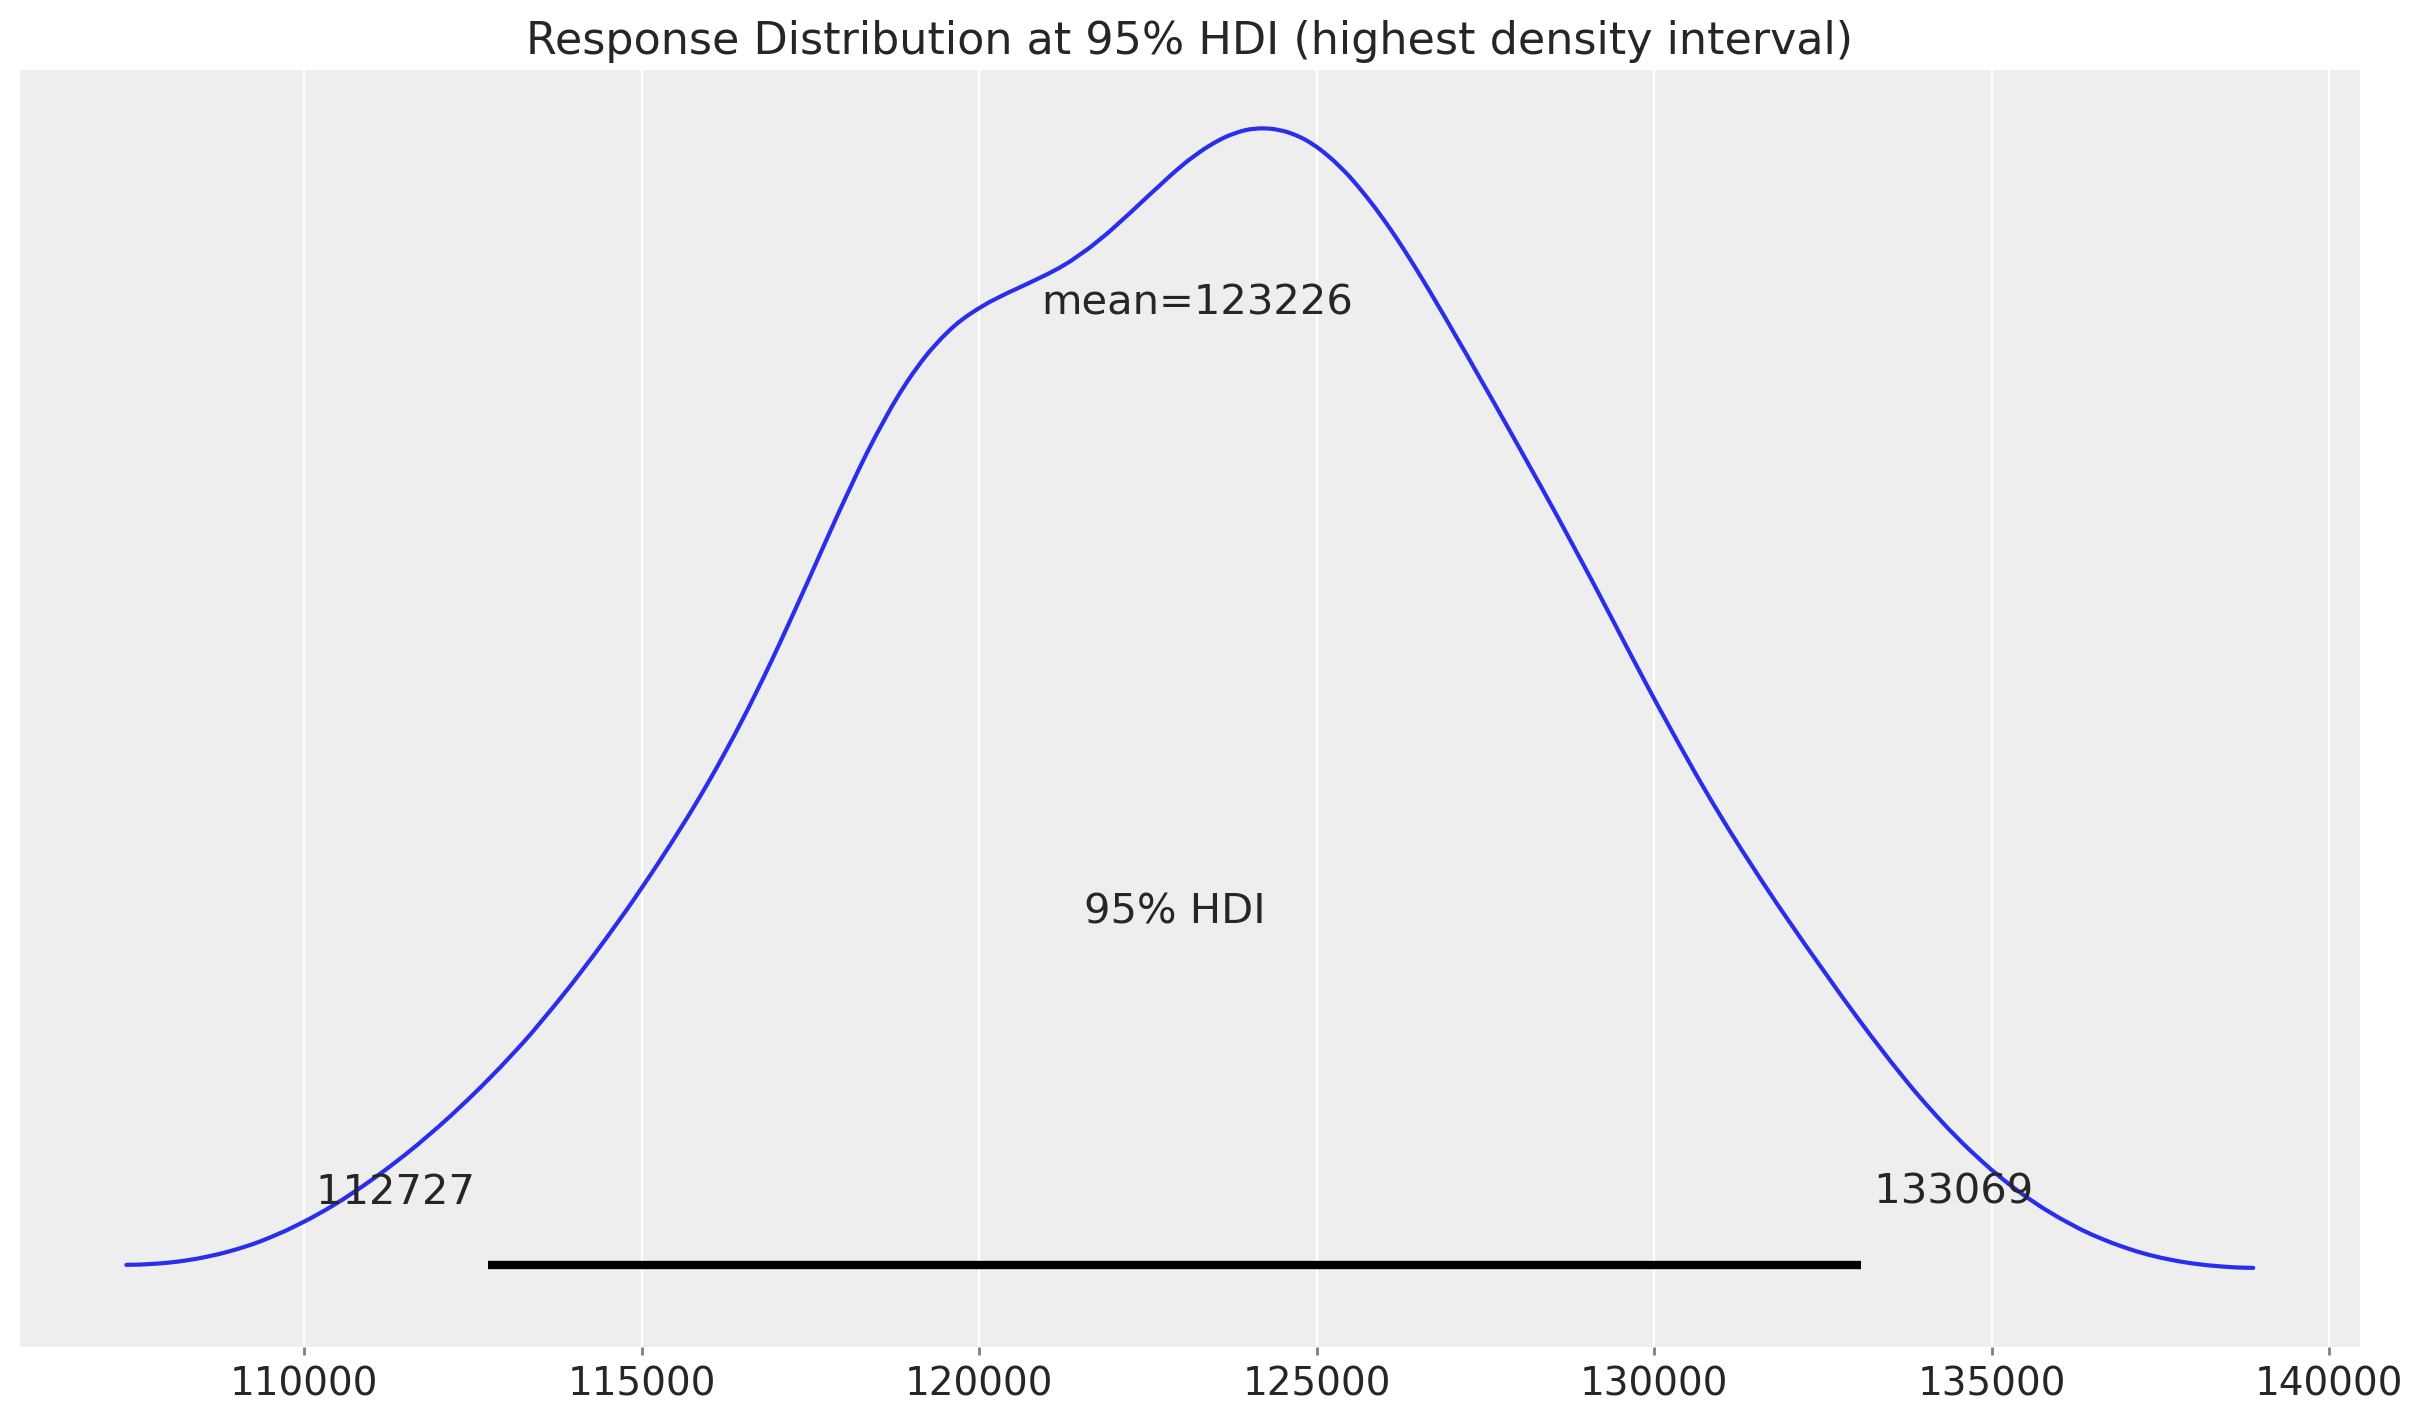

In [8]:
# Plot the response distribution by Arviz
az.plot_posterior(
    initial_posterior_response.total_media_contribution_original_scale.values,
    hdi_prob=0.95,
)
plt.title("Response Distribution at 95% HDI (highest density interval)");

This is great, apparently we could get 123,226 units sold given our 39,000 total budget (3,000 Daily) which is mostly allocated to $X2$.

Could we do better? The usual approach is to allocate the budget to maximize the response. We can use the `optimize_budget` method to do so, here we will compute the response given several budget combinations, and we'll prefer the one that maximizes the response. It's important to note that this example doesn't use any bounds, or constraints, so the optimizer will seek to use the entire budget.

Sampling: [y]


Budget allocation: [[706 788]
 [710 793]]
Total Allocated Budget: 3,000


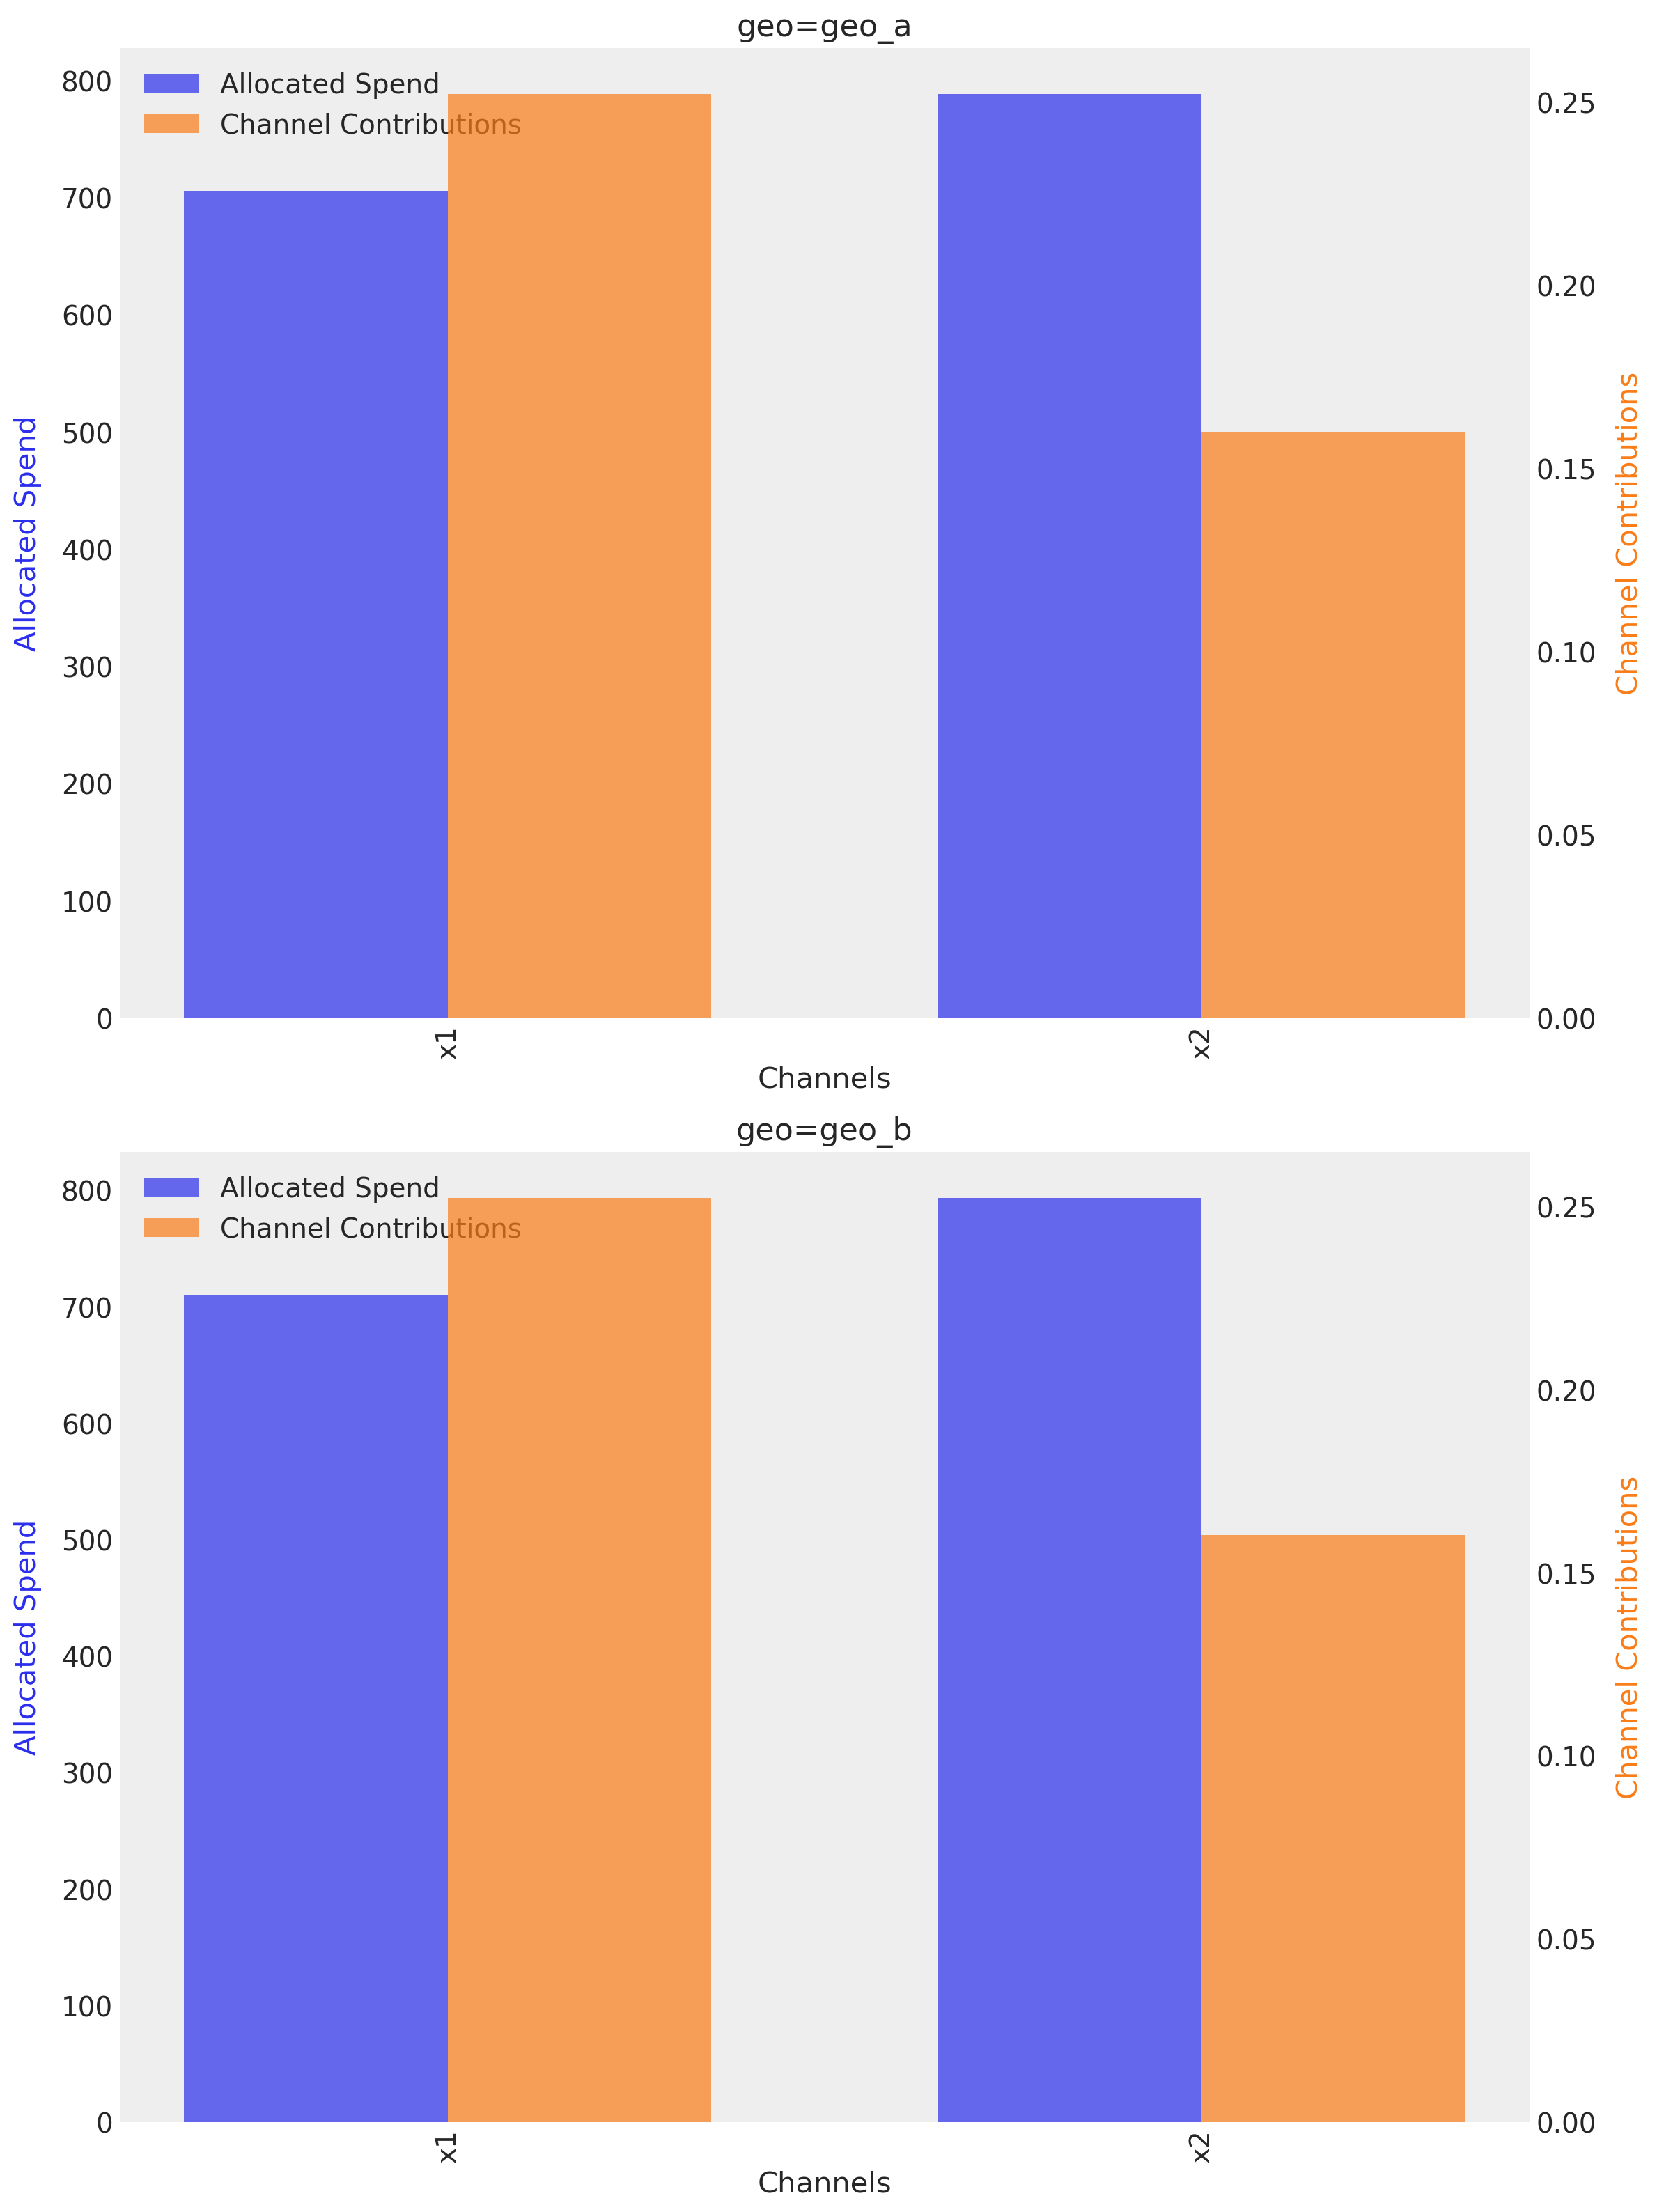

In [9]:
allocation_strategy, optimization_result = optimizable_model.optimize_budget(
    budget=time_unit_budget,
)

naive_posterior_response = optimizable_model.sample_response_distribution(
    allocation_strategy=allocation_strategy,
    include_carryover=True,
    include_last_observations=False,
)

print(
    f"Budget allocation: {naive_posterior_response.allocation.to_numpy().astype(int)}"
)
print(
    f"Total Allocated Budget: {np.sum(naive_posterior_response.allocation.to_numpy()):,.0f}"
)

fig, ax = optimizable_model.plot.budget_allocation(
    samples=naive_posterior_response, figsize=(12, 8)
)

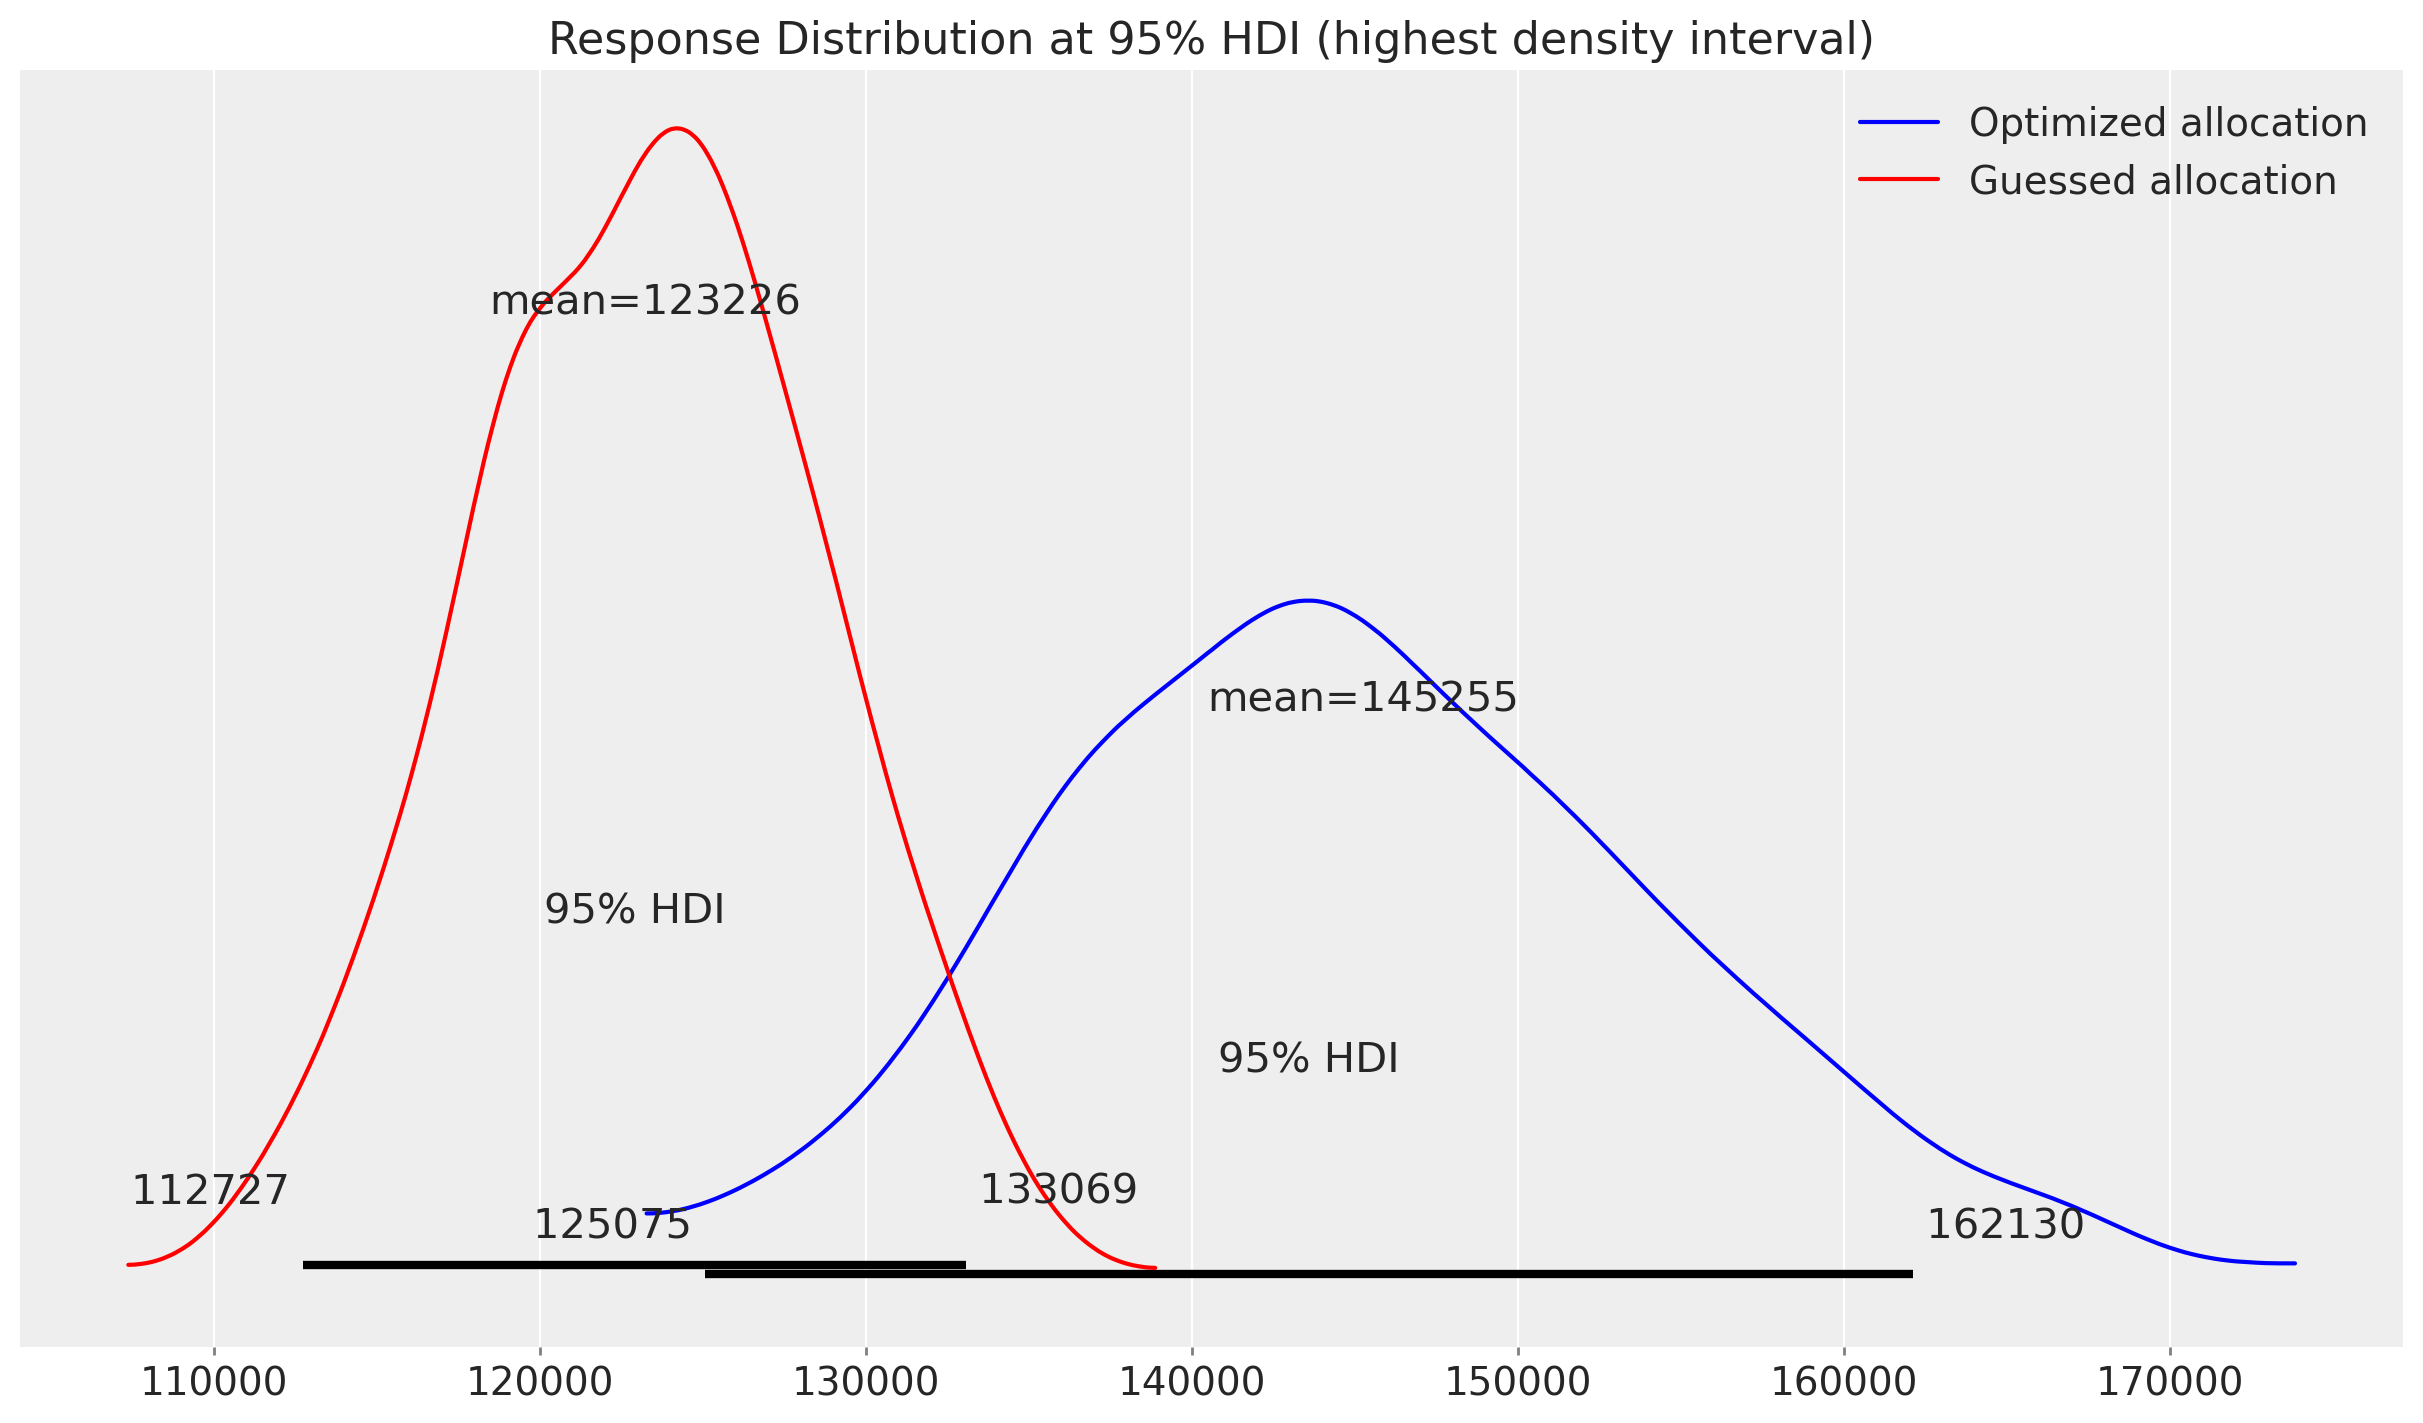

In [10]:
# Plot the response distribution by Arviz
fig, ax = plt.subplots()
az.plot_posterior(
    naive_posterior_response.total_media_contribution_original_scale.values,
    hdi_prob=0.95,
    color="blue",
    label="Optimized allocation",
    ax=ax,
)
az.plot_posterior(
    initial_posterior_response.total_media_contribution_original_scale.values,
    hdi_prob=0.95,
    color="red",
    label="Guessed allocation",
    ax=ax,
)
plt.title("Response Distribution at 95% HDI (highest density interval)")
plt.legend()
plt.show()

Great! Looks like we could get 145,255 units sold given our 3,000 time unit budget, meaning the optimizer found a better allocation which maximizes the response for the same budget. We could follow the same approach and plot the two distributions to compare them.

This makes everything clear, the optimized allocation has a higher mean. But looks like the optimized allocation has a higher risk, as the distribution is wider, respect to the initial guessed allocation.

Based on this, using the optimized allocation its very likely to get a respose of 145,255 units sold but also the budget could bring as low as 125,000 units sold or as big as 162,000 units sold. On the other hand, using the guessed allocation its very likely to get a respose of 123,000 units sold but also the budget could bring as low as 117,000 units sold or as big as 133,000 units sold. 

During this notebook will give you the tools to answer this question. If you face a situation where the best bet is not the safer bet, which one would you prefer? Higher mean, but with more risk? Or lower mean, but with less risk? A safer bet or a riskier bet?

This is where risk assessment comes into play, we can use different risk assessment criteria to help us decide which allocation is better based on our risk tolerance.

## Introduction to Risk Assessment

The `budget_optimizer` module encompasses various risk assessment criteria that facilitate the evaluation of risks associated with different budget allocations.

Utilization of the `ut` class allows for the computation of risks linked to various budget allocations. Should the need arise to implement a customized risk assessment criterion, one can develop an individual function and incorporate it into the `optimize_budget` method as necessary. Subsequently, guidance on creating a personalized risk assessment criterion will be provided. 

In [11]:
from pymc_marketing.mmm import utility as ut

## Optimizing Budget Allocation Using Mean Tightness Score (MTS)

This section focuses on the optimization of marketing budget allocation while incorporating risk considerations. Specifically, we employ the Mean Tightness Score (MTS) as the utility function to ensure that our budget plan effectively minimizes potential losses within a defined HDI (highest density interval).

### Overview of the Process

We invoke `mmm.optimize_budget` to ascertain the optimal allocation of the marketing budget across various channels over specified time periods, mirroring the approach undertaken in the prior section.

The parameters remain consistent with those from the preceding section, with the addition of the `utility_function` parameters. In this instance:
- `utility_function`: This parameter is assigned to `mean_tightness_score`.

The Mean Tightness Score represents a risk-adjusted metric that harmonizes the mean return with the tail variability within a distribution. This metric is computed as follows:

$$
Mean\ Tightness\ Score = (\mu - \alpha \cdot Tail\ Distance) / \mu
$$

In this formula, $\mu$ signifies the mean of the sample returns, $Tail\ Distance$ represents the tail distance metric, and $\alpha$ denotes the risk tolerance parameter.

In [12]:
ut.mean_tightness_score?

Signature: ut.mean_tightness_score(alpha: float = 0.5, confidence_level: float = 0.75) -> collections.abc.Callable[[pytensor.tensor.variable.TensorVariable, pytensor.tensor.variable.TensorVariable], float]
Docstring:
Calculate the mean tightness score.

The mean tightness score is a risk metric that balances the mean return and the tail variability.
It is calculated as:

.. math::
    Mean\ Tightness\ Score = \mu - \alpha \cdot Tail\ Distance / \mu

where:
    - :math:`\mu` is the mean of the sample returns.
    - :math:`Tail\ Distance` is the tail distance metric.
    - :math:`\alpha` is the risk tolerance parameter.

alpha (Risk Tolerance Parameter): This parameter controls the trade-off.
    - Higher :math:`\alpha` increases sensitivity to variability, making the metric value higher for spread dist
    - Lower :math:`\alpha` decreases sensitivity to variability, making the metric value lower for spread dist

Parameters
----------
alpha : float, optional
    Risk tolerance parameter 

In [13]:
mts_budget_allocation, mts_optimizer_result, callback_results = (
    optimizable_model.optimize_budget(
        budget=time_unit_budget,
        utility_function=ut.mean_tightness_score(alpha=0.15, confidence_level=0.85),
        callback=True,
        minimize_kwargs={"options": {"maxiter": 2_000, "ftol": 1e-16}},
    )
)

mts_posterior_response = optimizable_model.sample_response_distribution(
    allocation_strategy=mts_budget_allocation,
    include_carryover=True,
    include_last_observations=False,
)

# Print budget allocation by channel
print("Budget allocation by channel:")
for channel in channels:
    print(
        f"  {channel}: {mts_posterior_response.allocation.sel(channel=channel).astype(int).sum():,}"
    )
print(
    f"Total Allocated Budget: {np.sum(mts_posterior_response.allocation.to_numpy()):,.0f}"
)

Sampling: [y]


Budget allocation by channel:
  x1: 2,318
  x2: 680
Total Allocated Budget: 3,000


In [14]:
mts_optimizer_result

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: -0.9876647943501864
           x: [ 2.237e+03  1.780e+02  8.221e+01  5.032e+02]
         nit: 207
         jac: [ 1.250e-07  8.391e-07 -1.983e-06  6.947e-06]
        nfev: 522
        njev: 207
 multipliers: [ 1.288e-07]

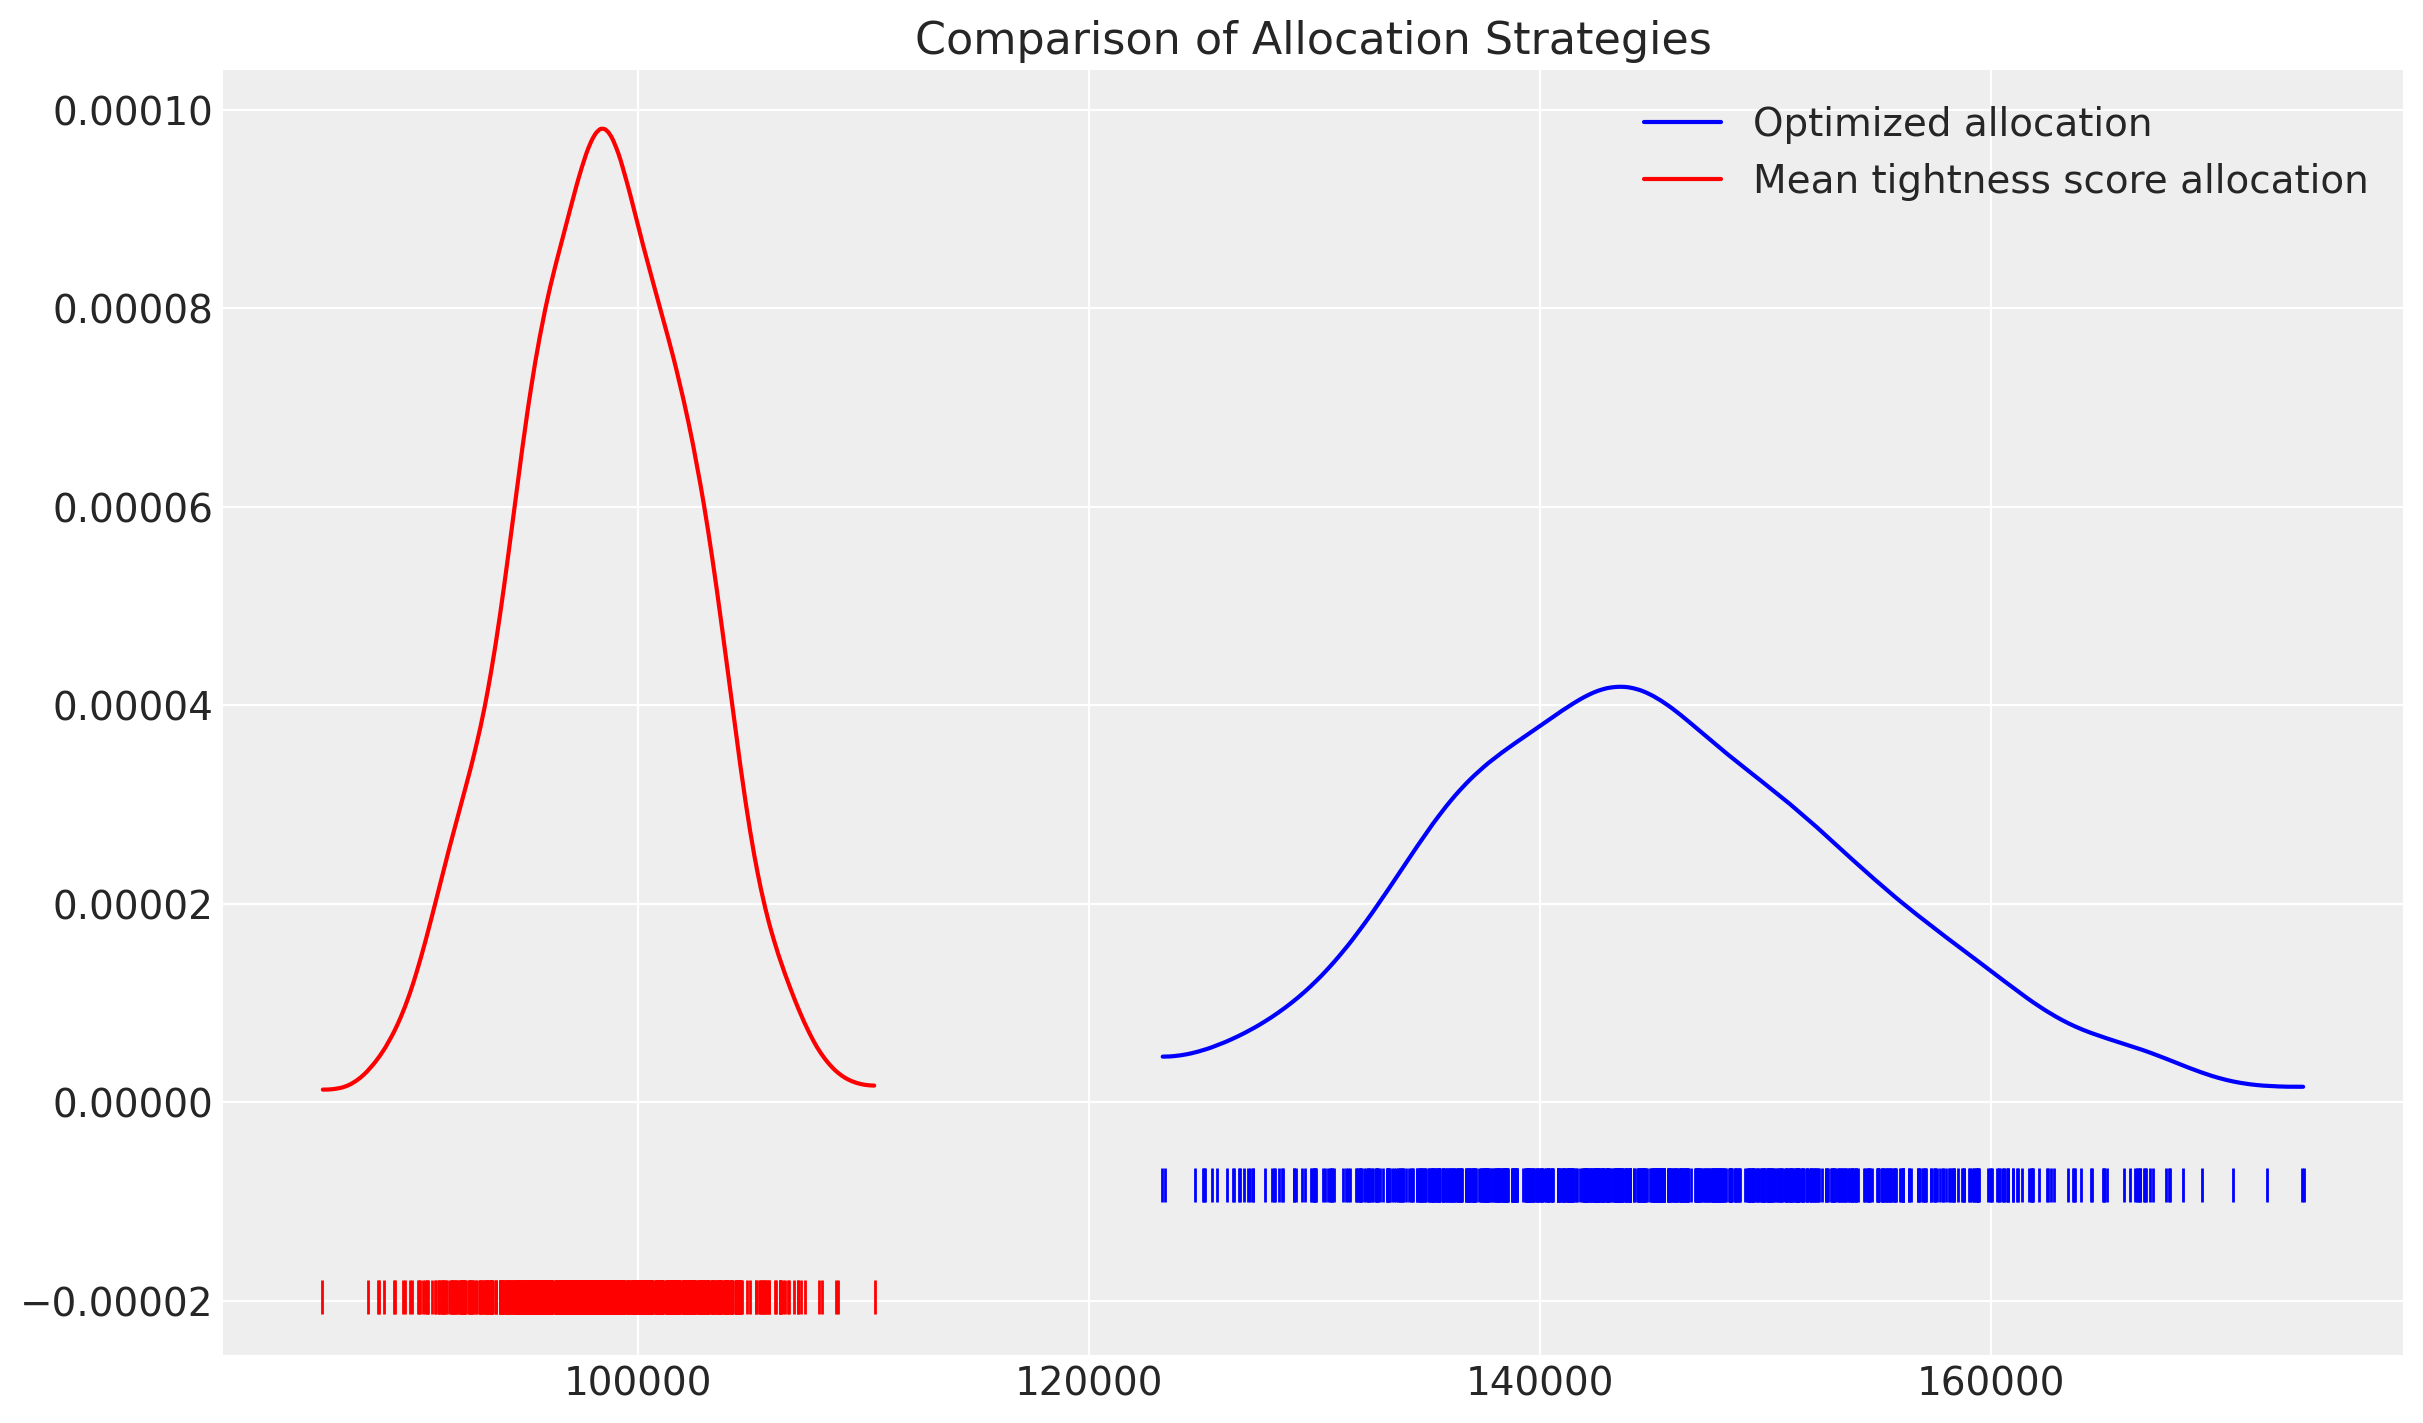

In [15]:
fig, ax = plt.subplots(figsize=(12, 7))
az.plot_dist(
    naive_posterior_response.total_media_contribution_original_scale.values,
    # hdi_prob=0.85,
    color="blue",
    label="Optimized allocation",
    # kind="hist",
    rug=True,
    ax=ax,
)
az.plot_dist(
    mts_posterior_response.total_media_contribution_original_scale.values,
    # hdi_prob=0.85,
    color="red",
    label="Mean tightness score allocation",
    # kind="hist",
    rug=True,
    ax=ax,
)
plt.legend()
plt.title("Comparison of Allocation Strategies");

The majority of the budget is allocated to $X1$. This allocation has been determined to minimize potential risk. Essentially, this approach indicates that we are prepared to accept lower returns if those returns are characterized by a higher degree of certainty. This is evident in the response distribution plot, which should exhibit a tight distribution with narrow tails.

Now the budget change quite a bit, but the risk is lower compared to the non-risk optimized allocation, if we observe the distributions the density is narrower for the MTS optimized allocation.

This strategy is logical, as $X1$ demonstrates a response with reduced uncertainty, whereas $X2$ is associated with greater uncertainty. Consequently, the optimizer allocates a larger portion of the budget to $X1$, as it represents a more secure investment option.

Sampling: []


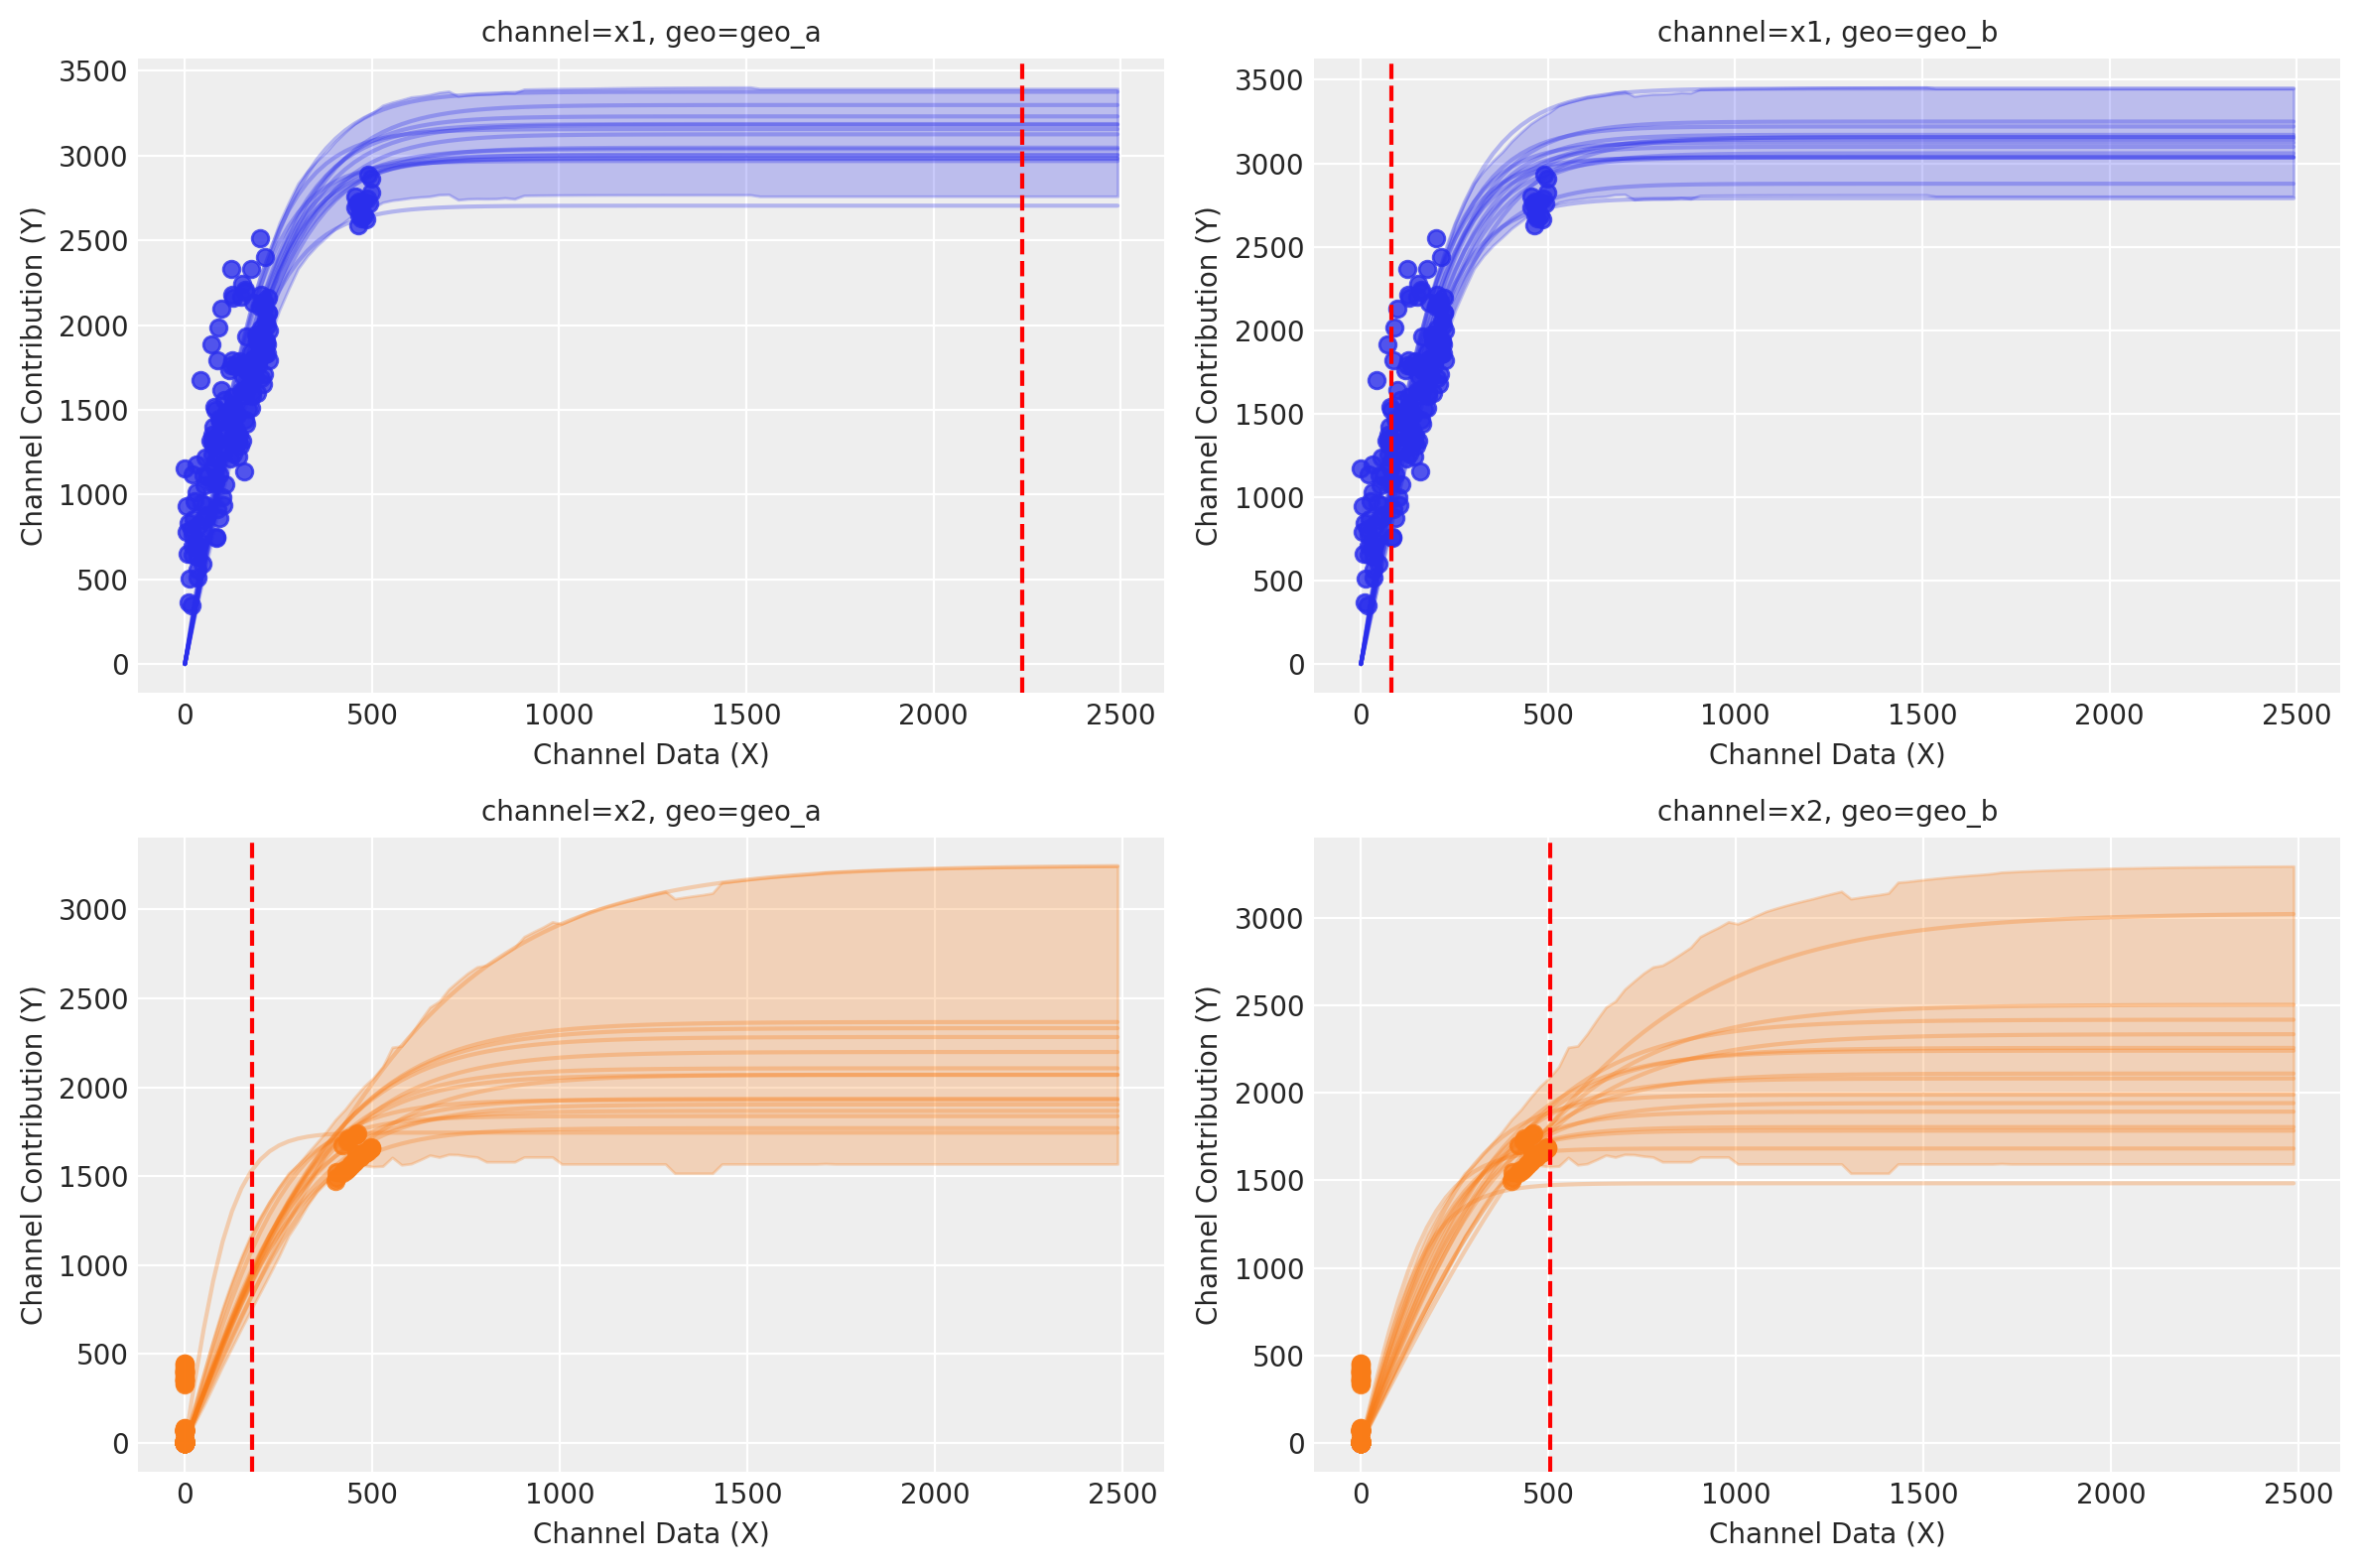

In [16]:
curve = mmm.saturation.sample_curve(
    mmm.idata.posterior[["saturation_beta", "saturation_lam"]], max_value=5
)
fig, axes = mmm.plot.saturation_curves(
    curve,
    original_scale=True,
    n_samples=15,
    hdi_probs=0.94,
    subplot_kwargs={"figsize": (12, 8), "ncols": 2},
    rc_params={
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.labelsize": 10,
        "axes.titlesize": 10,
    },
)

# Iterate over all channel-geo combinations
subplot_idx = 0
for channel in channels:
    for geo in geos:
        # Make sure we're accessing the correct axis object
        ax = axes.flat[subplot_idx] if isinstance(axes, np.ndarray) else axes

        # Get the budget value for this specific channel-geo combination
        budget_value = mts_posterior_response.allocation.sel(
            channel=channel, geo=geo
        ).item()

        # Add vertical line with a label
        ax.axvline(
            x=budget_value,
            color="red",
            linestyle="--",
            label=f"{channel}-{geo}: {budget_value:.1f}",
        )

        subplot_idx += 1

# Ensure we're working with actual axes objects, not numpy arrays
for i in range(len(channels) * len(geos)):
    ax = axes.flat[i] if isinstance(axes, np.ndarray) else axes
    if hasattr(ax, "title"):
        ax.title.set_fontsize(10)

if hasattr(fig, "_suptitle") and fig._suptitle is not None:
    fig._suptitle.set_fontsize(12)

plt.tight_layout()
plt.show()

We can exhibit this behavior on a more evident way; if we want to maximize a response that is less certain, we should get the opposite scenario. Let's set the mean tightness score with a lower alpha parameter, meaning, we have a higher risk tolerance.

In [17]:
(
    mts_budget_allocation_high_risk,
    mts_optimizer_result_high_risk,
    callback_results_high_risk,
) = optimizable_model.optimize_budget(
    budget=time_unit_budget,
    utility_function=ut.mean_tightness_score(alpha=0.95),
    callback=True,
    minimize_kwargs={"options": {"maxiter": 2_000, "ftol": 1e-16}},
)

mts_posterior_response_high_risk = optimizable_model.sample_response_distribution(
    allocation_strategy=mts_budget_allocation_high_risk,
    include_carryover=True,
    include_last_observations=False,
)

for channel in channels:
    print(
        f"  {channel}: {mts_posterior_response_high_risk.allocation.sel(channel=channel).astype(int).sum():,}"
    )
print(
    f"Total Allocated Budget: {np.sum(mts_posterior_response_high_risk.allocation.to_numpy()):,.0f}"
)

Sampling: [y]


  x1: 2,064
  x2: 934
Total Allocated Budget: 3,000


We are spending more in $X2$, and less in $X1$ compared to the previous allocation. Let's see the response distribution plot, again to compare it with the previous one.

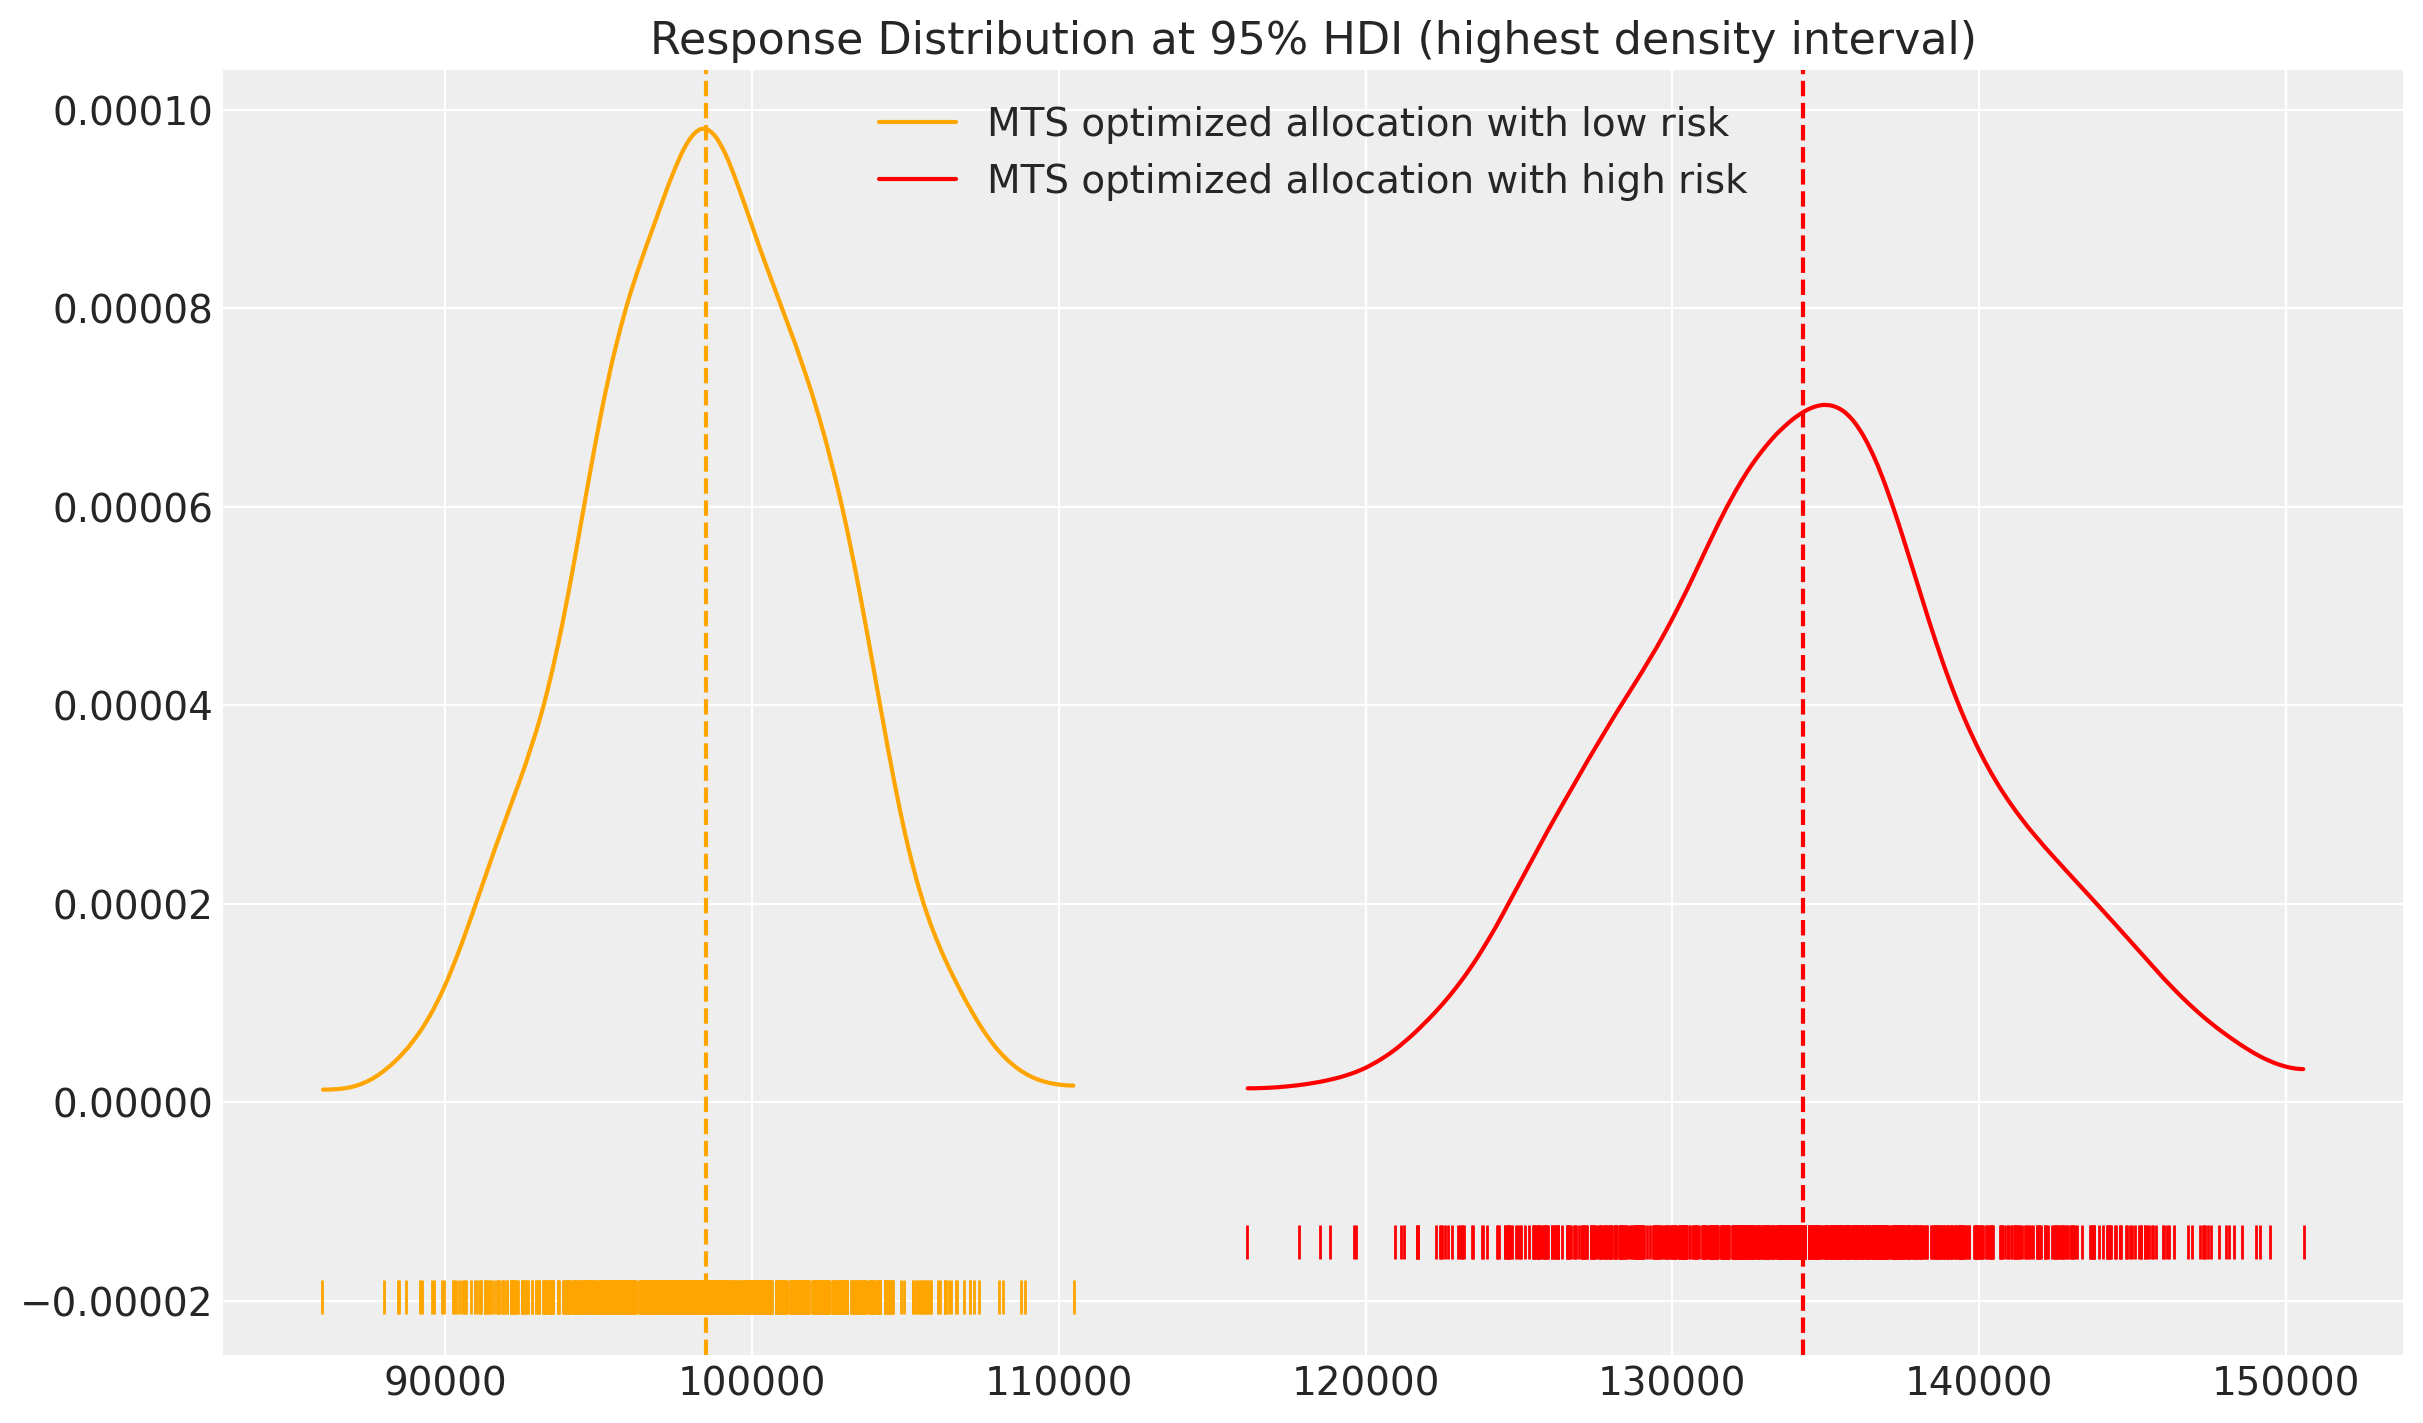

In [18]:
fig, ax = plt.subplots()
az.plot_dist(
    mts_posterior_response.total_media_contribution_original_scale.values,
    color="orange",
    label="MTS optimized allocation with low risk",
    ax=ax,
    rug=True,
)
az.plot_dist(
    mts_posterior_response_high_risk.total_media_contribution_original_scale.values,
    color="red",
    label="MTS optimized allocation with high risk",
    ax=ax,
    rug=True,
)
plt.axvline(
    x=mts_posterior_response.total_media_contribution_original_scale.values.mean(),
    color="orange",
    linestyle="--",
)
plt.axvline(
    x=mts_posterior_response_high_risk.total_media_contribution_original_scale.values.mean(),
    color="red",
    linestyle="--",
)
plt.title("Response Distribution at 95% HDI (highest density interval)")
plt.legend()
plt.show()

As expected, the distribution has bigger tails now, and the mean is higher as well. We got bigger returns, but with more risk. The extra risk is coming from the additional budget allocated to $X2$.

Sampling: []


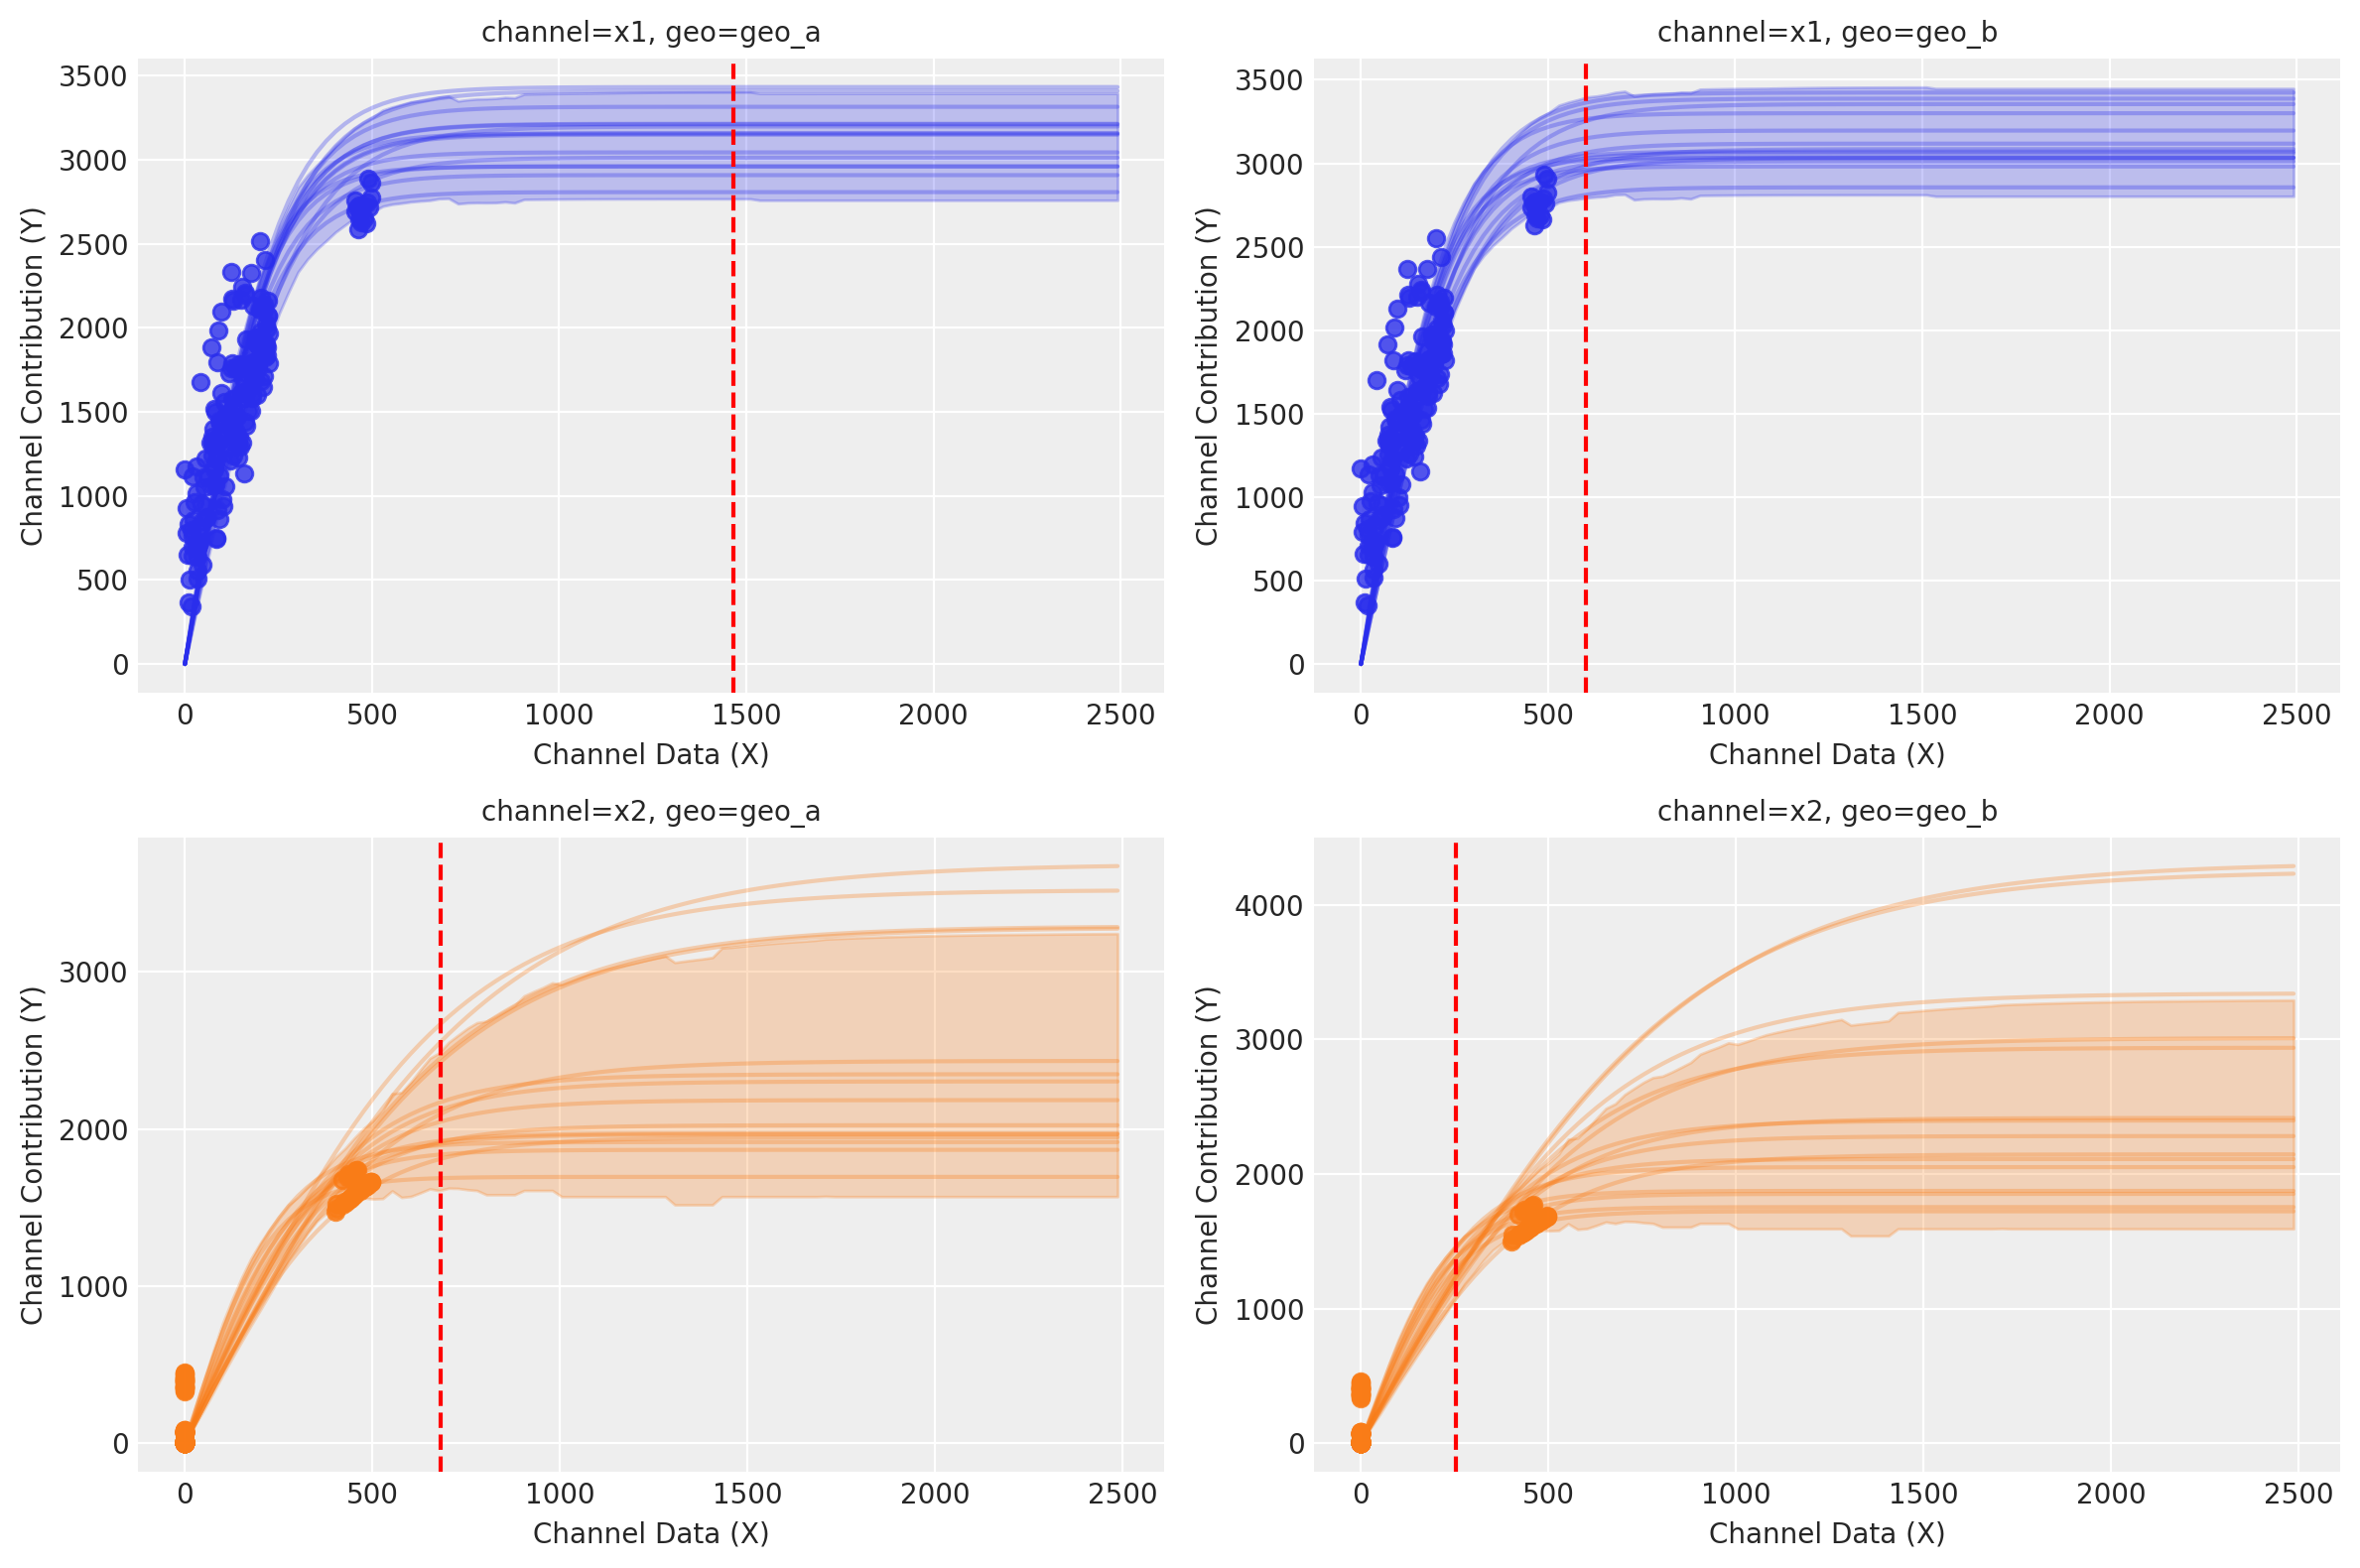

In [19]:
curve = mmm.saturation.sample_curve(
    mmm.idata.posterior[["saturation_beta", "saturation_lam"]], max_value=5
)
fig, axes = mmm.plot.saturation_curves(
    curve,
    original_scale=True,
    n_samples=15,
    hdi_probs=0.94,
    subplot_kwargs={"figsize": (12, 8), "ncols": 2},
    rc_params={
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.labelsize": 10,
        "axes.titlesize": 10,
    },
)

# Iterate over all channel-geo combinations
subplot_idx = 0
for channel in channels:
    for geo in geos:
        # Make sure we're accessing the correct axis object
        ax = axes.flat[subplot_idx] if isinstance(axes, np.ndarray) else axes

        # Get the budget value for this specific channel-geo combination
        budget_value = mts_posterior_response_high_risk.allocation.sel(
            channel=channel, geo=geo
        ).item()

        # Add vertical line with a label
        ax.axvline(
            x=budget_value,
            color="red",
            linestyle="--",
            label=f"{channel}-{geo}: {budget_value:.1f}",
        )

        subplot_idx += 1

# Ensure we're working with actual axes objects, not numpy arrays
for i in range(len(channels) * len(geos)):
    ax = axes.flat[i] if isinstance(axes, np.ndarray) else axes
    if hasattr(ax, "title"):
        ax.title.set_fontsize(10)

if hasattr(fig, "_suptitle") and fig._suptitle is not None:
    fig._suptitle.set_fontsize(12)

plt.tight_layout()
plt.show()

## Optimizing Budget Allocation through ROAS and Value at Risk (VaR)

In order to enhance decision-making regarding budget allocation, we can integrate various risk assessment criteria to develop a more sophisticated utility function. In this context, we will utilize the Return on Advertising Spend (ROAS) associated with each allocation, alongside the Value at Risk (VaR) as our risk assessment criterion. This approach will facilitate the identification of the allocation that maximizes ROAS while concurrently minimizing potential risks.

Value at Risk is a statistical method employed to quantify the risk of financial loss within a portfolio or investment. Within the realm of marketing, it assists in understanding the potential worst-case loss (ROAS) associated with a particular budget allocation, evaluated at a specified HDI (highest density interval). By minimizing VaR, we aim to select an allocation that ensures, even in adverse scenarios, the ROAS remains as elevated as feasibly possible.

In [20]:
def value_at_roas(confidence_level=0.9):
    """Calculate the Value at Risk (VaR) based on the ROAS distribution."""

    def _value_at_roas(samples, budgets):
        roas_samples = ut._calculate_roas_distribution_for_allocation(samples, budgets)
        return ut.value_at_risk(confidence_level=confidence_level)(
            samples=roas_samples, budgets=budgets
        )

    return _value_at_roas

In [22]:
mts_roas_budget_allocation, mts_roas_optimizer_result, callback_results_roas = (
    optimizable_model.optimize_budget(
        budget=time_unit_budget,
        utility_function=value_at_roas(confidence_level=0.75),
        callback=True,
        minimize_kwargs={"options": {"maxiter": 2_000, "ftol": 1e-16}},
    )
)

mts_roas_posterior_response = optimizable_model.sample_response_distribution(
    allocation_strategy=mts_roas_budget_allocation,
    include_carryover=True,
    include_last_observations=False,
)

for channel in channels:
    print(
        f"  {channel}: {mts_roas_posterior_response.allocation.sel(channel=channel).astype(int).sum():,}"
    )
print(
    f"Total Allocated Budget: {np.sum(mts_roas_posterior_response.allocation.to_numpy()):,.0f}"
)

Sampling: [y]


  x1: 1,520
  x2: 1,477
Total Allocated Budget: 3,000


In [23]:
mts_roas_optimizer_result

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: -46.210610155140486
           x: [ 7.580e+02  7.374e+02  7.637e+02  7.409e+02]
         nit: 90
         jac: [ 1.377e-02  1.314e-02  1.377e-02  1.314e-02]
        nfev: 210
        njev: 90
 multipliers: [ 1.373e-02]

The optimizer is once again allocating the budget to $X1$ majority, nevertheless $X2$ it's getting more money this time. However, this decision is informed by the expectation that the current combination will yield a higher Return on Advertising Spend (ROAS), while also presenting a small lower risk profile compared to the previous allocation.

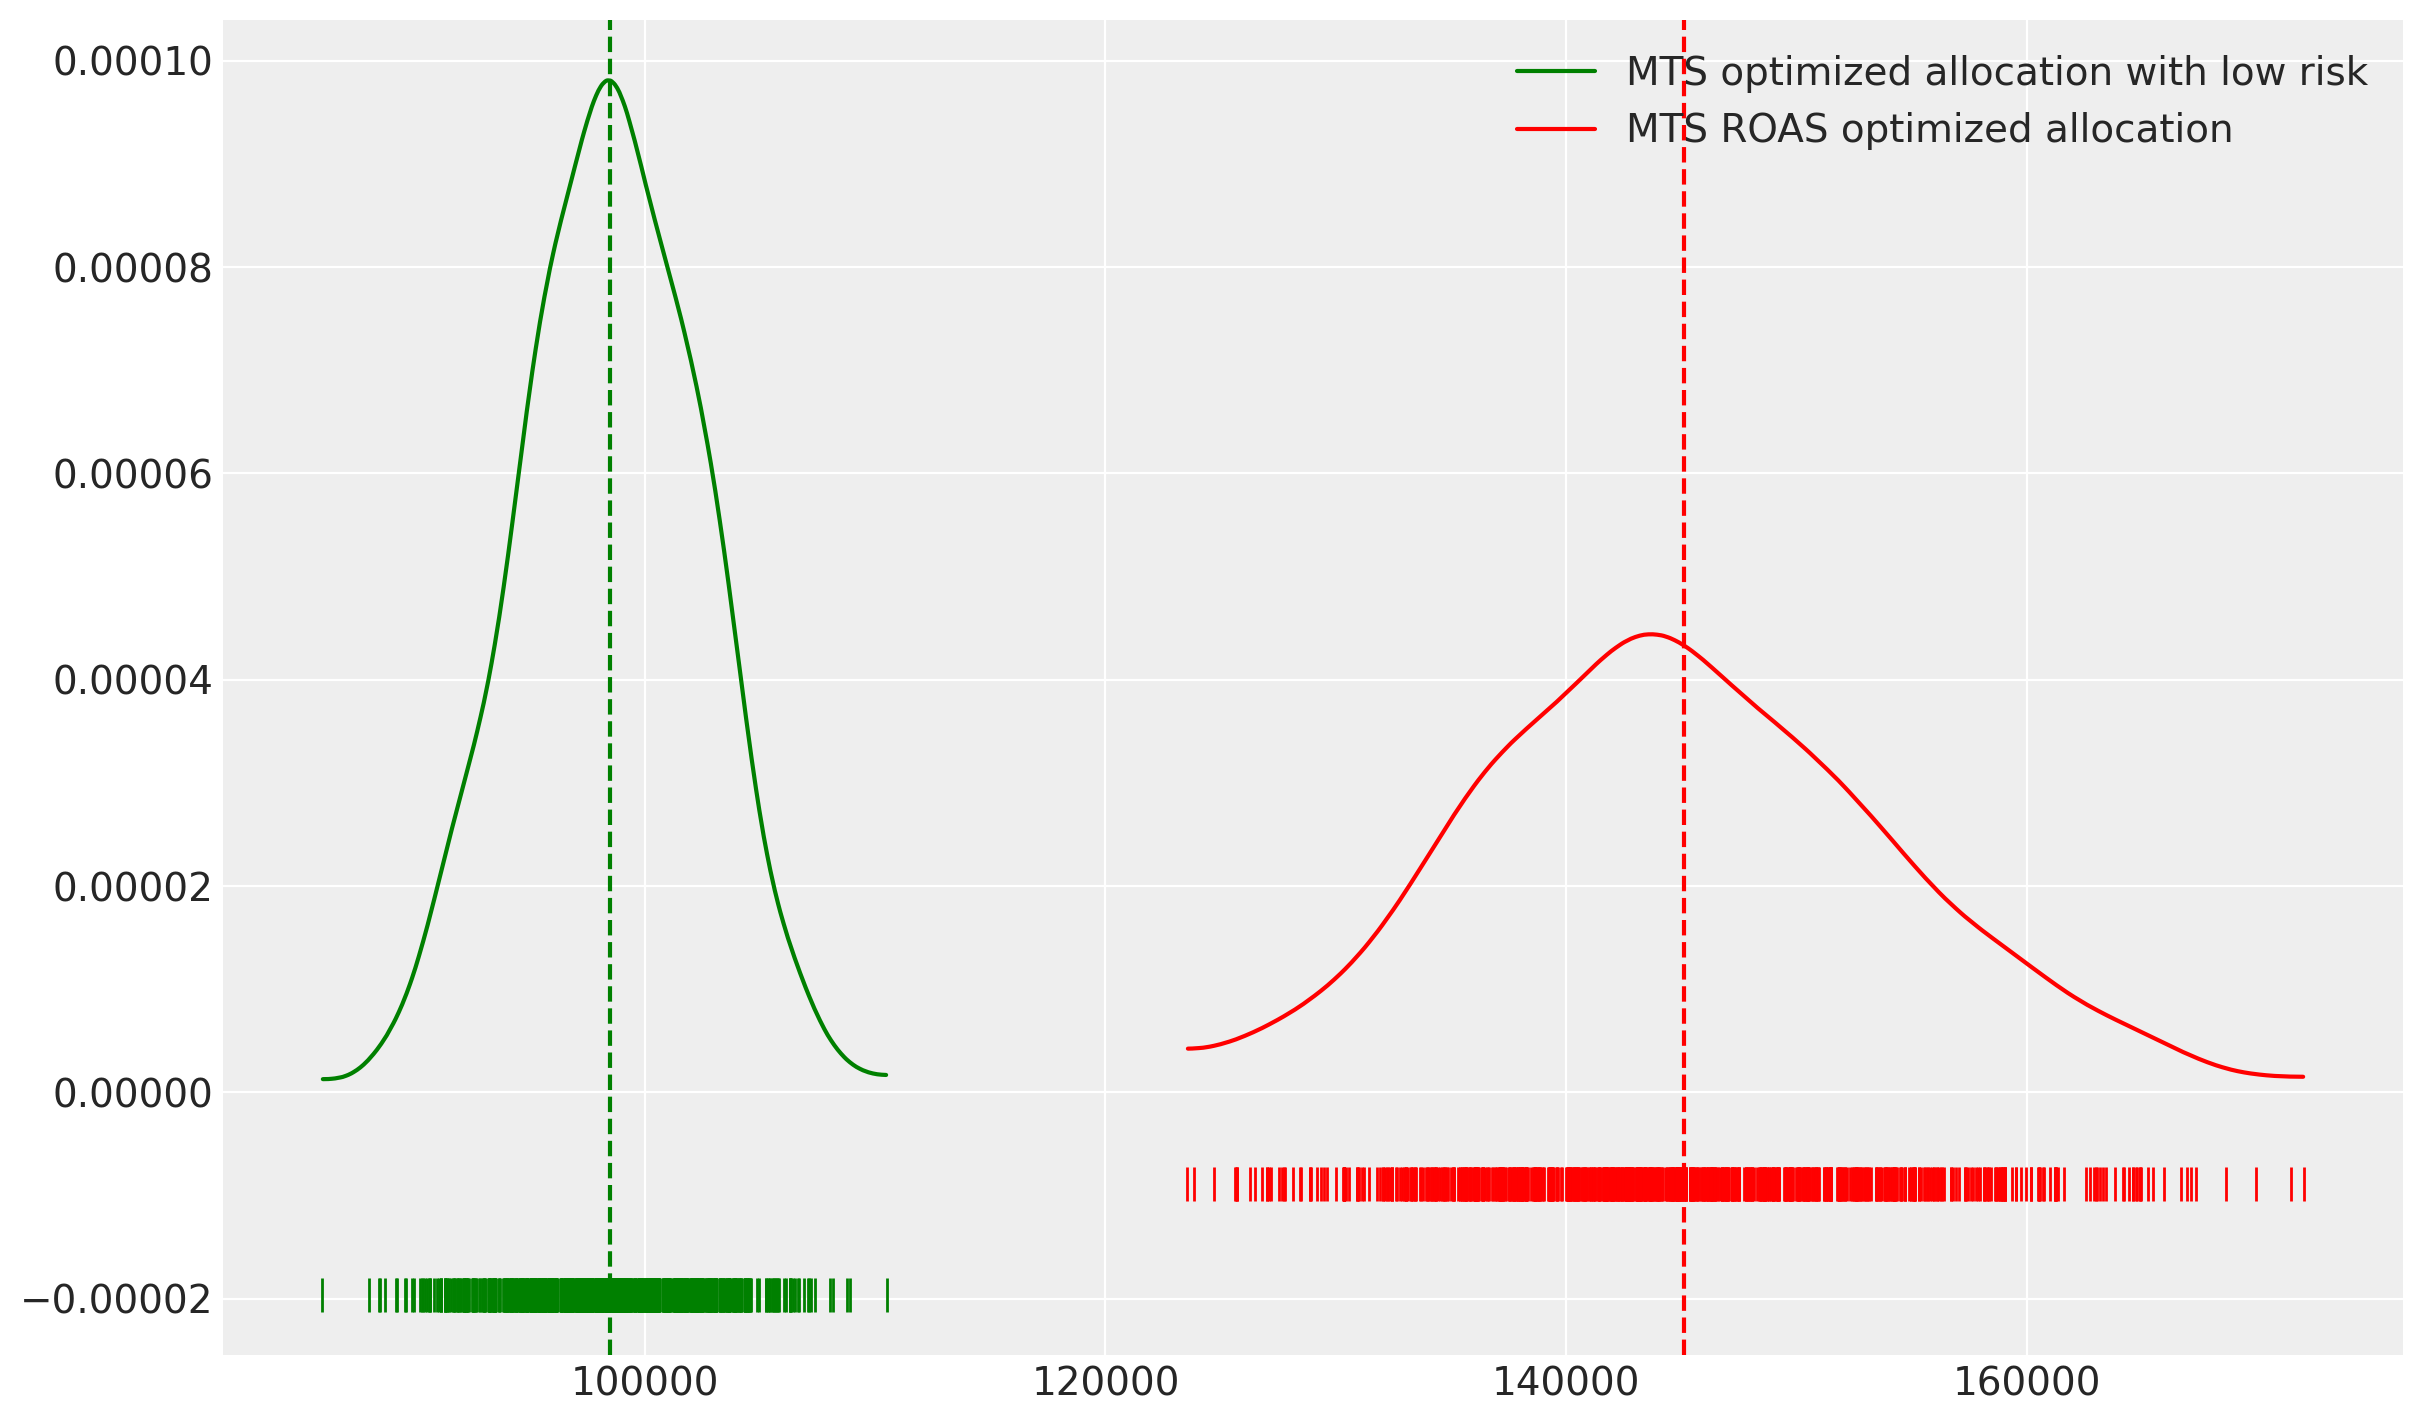

In [24]:
fig, ax = plt.subplots()
az.plot_dist(
    mts_posterior_response.total_media_contribution_original_scale.values,
    color="green",
    label="MTS optimized allocation with low risk",
    ax=ax,
    rug=True,
)
az.plot_dist(
    mts_roas_posterior_response.total_media_contribution_original_scale.values,
    color="red",
    label="MTS ROAS optimized allocation",
    ax=ax,
    rug=True,
)
plt.axvline(
    x=mts_posterior_response.total_media_contribution_original_scale.values.mean(),
    color="green",
    linestyle="--",
)
plt.axvline(
    x=mts_roas_posterior_response.total_media_contribution_original_scale.values.mean(),
    color="red",
    linestyle="--",
)
plt.legend()
plt.show()

## Custom Risk Assessment Criterion
We have the capacity to establish a bespoke risk assessment criterion by formulating a function that inputs the samples and assets and outputs a scalar value to be optimized. In this context, our objective is to maximize the value at risk, with particular consideration given to the diversification ratio.

We aim to favor allocation strategies that exhibit the highest mean tightness score, while simultaneously ensuring a high level of diversification across marketing channels. As we already possess a foundational understanding of value at risk, we will concentrate our efforts on portfolio entropy.

In [25]:
(
    ut.portfolio_entropy(samples=None, budgets=np.array([0.1, 9.9])).eval(),
    ut.portfolio_entropy(samples=None, budgets=np.array([5, 5])).eval(),
)

(array(0.05600153), array(0.69314718))

We can see that the portfolio entropy is higher when the budget is allocated evenly, meaning that the diversification is higher.

Now, we can create our own risk assessment criterion by combining the value at risk and the portfolio entropy. In this case, we'll compute the mean tightness score and will multiply the response by the entropy in the portafolio. This will moderate our score, and we'll prefer the allocation that has the highest score, but with a high diversification between the marketing channels.

In [26]:
def mts_with_diversification(alpha, confidence_level):
    def _mts_with_diversification(samples, budgets):
        return ut.mean_tightness_score(alpha, confidence_level)(samples, budgets) * (
            1 + ut.portfolio_entropy(samples=None, budgets=budgets)
        )

    return _mts_with_diversification

In [27]:
(
    mts_diversification_budget_allocation,
    mts_diversification_optimizer_result,
    callback_results_diversification,
) = optimizable_model.optimize_budget(
    budget=time_unit_budget,
    utility_function=mts_with_diversification(alpha=0.9, confidence_level=0.7),
    callback=True,
    minimize_kwargs={"options": {"maxiter": 2_000, "ftol": 1e-16}},
)

mts_diversification_posterior_response = optimizable_model.sample_response_distribution(
    allocation_strategy=mts_diversification_budget_allocation,
    include_carryover=True,
    include_last_observations=False,
)

for channel in channels:
    print(
        f"  {channel}: {mts_diversification_posterior_response.allocation.sel(channel=channel).astype(int).sum():,}"
    )
print(
    f"Total Allocated Budget: {np.sum(mts_diversification_posterior_response.allocation.to_numpy()):,.0f}"
)

Sampling: [y]


  x1: 1,677
  x2: 1,320
Total Allocated Budget: 3,000


In [28]:
mts_diversification_optimizer_result

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: -2.2608194273059325
           x: [ 8.399e+02  6.639e+02  8.389e+02  6.572e+02]
         nit: 92
         jac: [ 5.359e-05  2.108e-05  5.361e-05  2.029e-05]
        nfev: 139
        njev: 92
 multipliers: [ 5.218e-05]

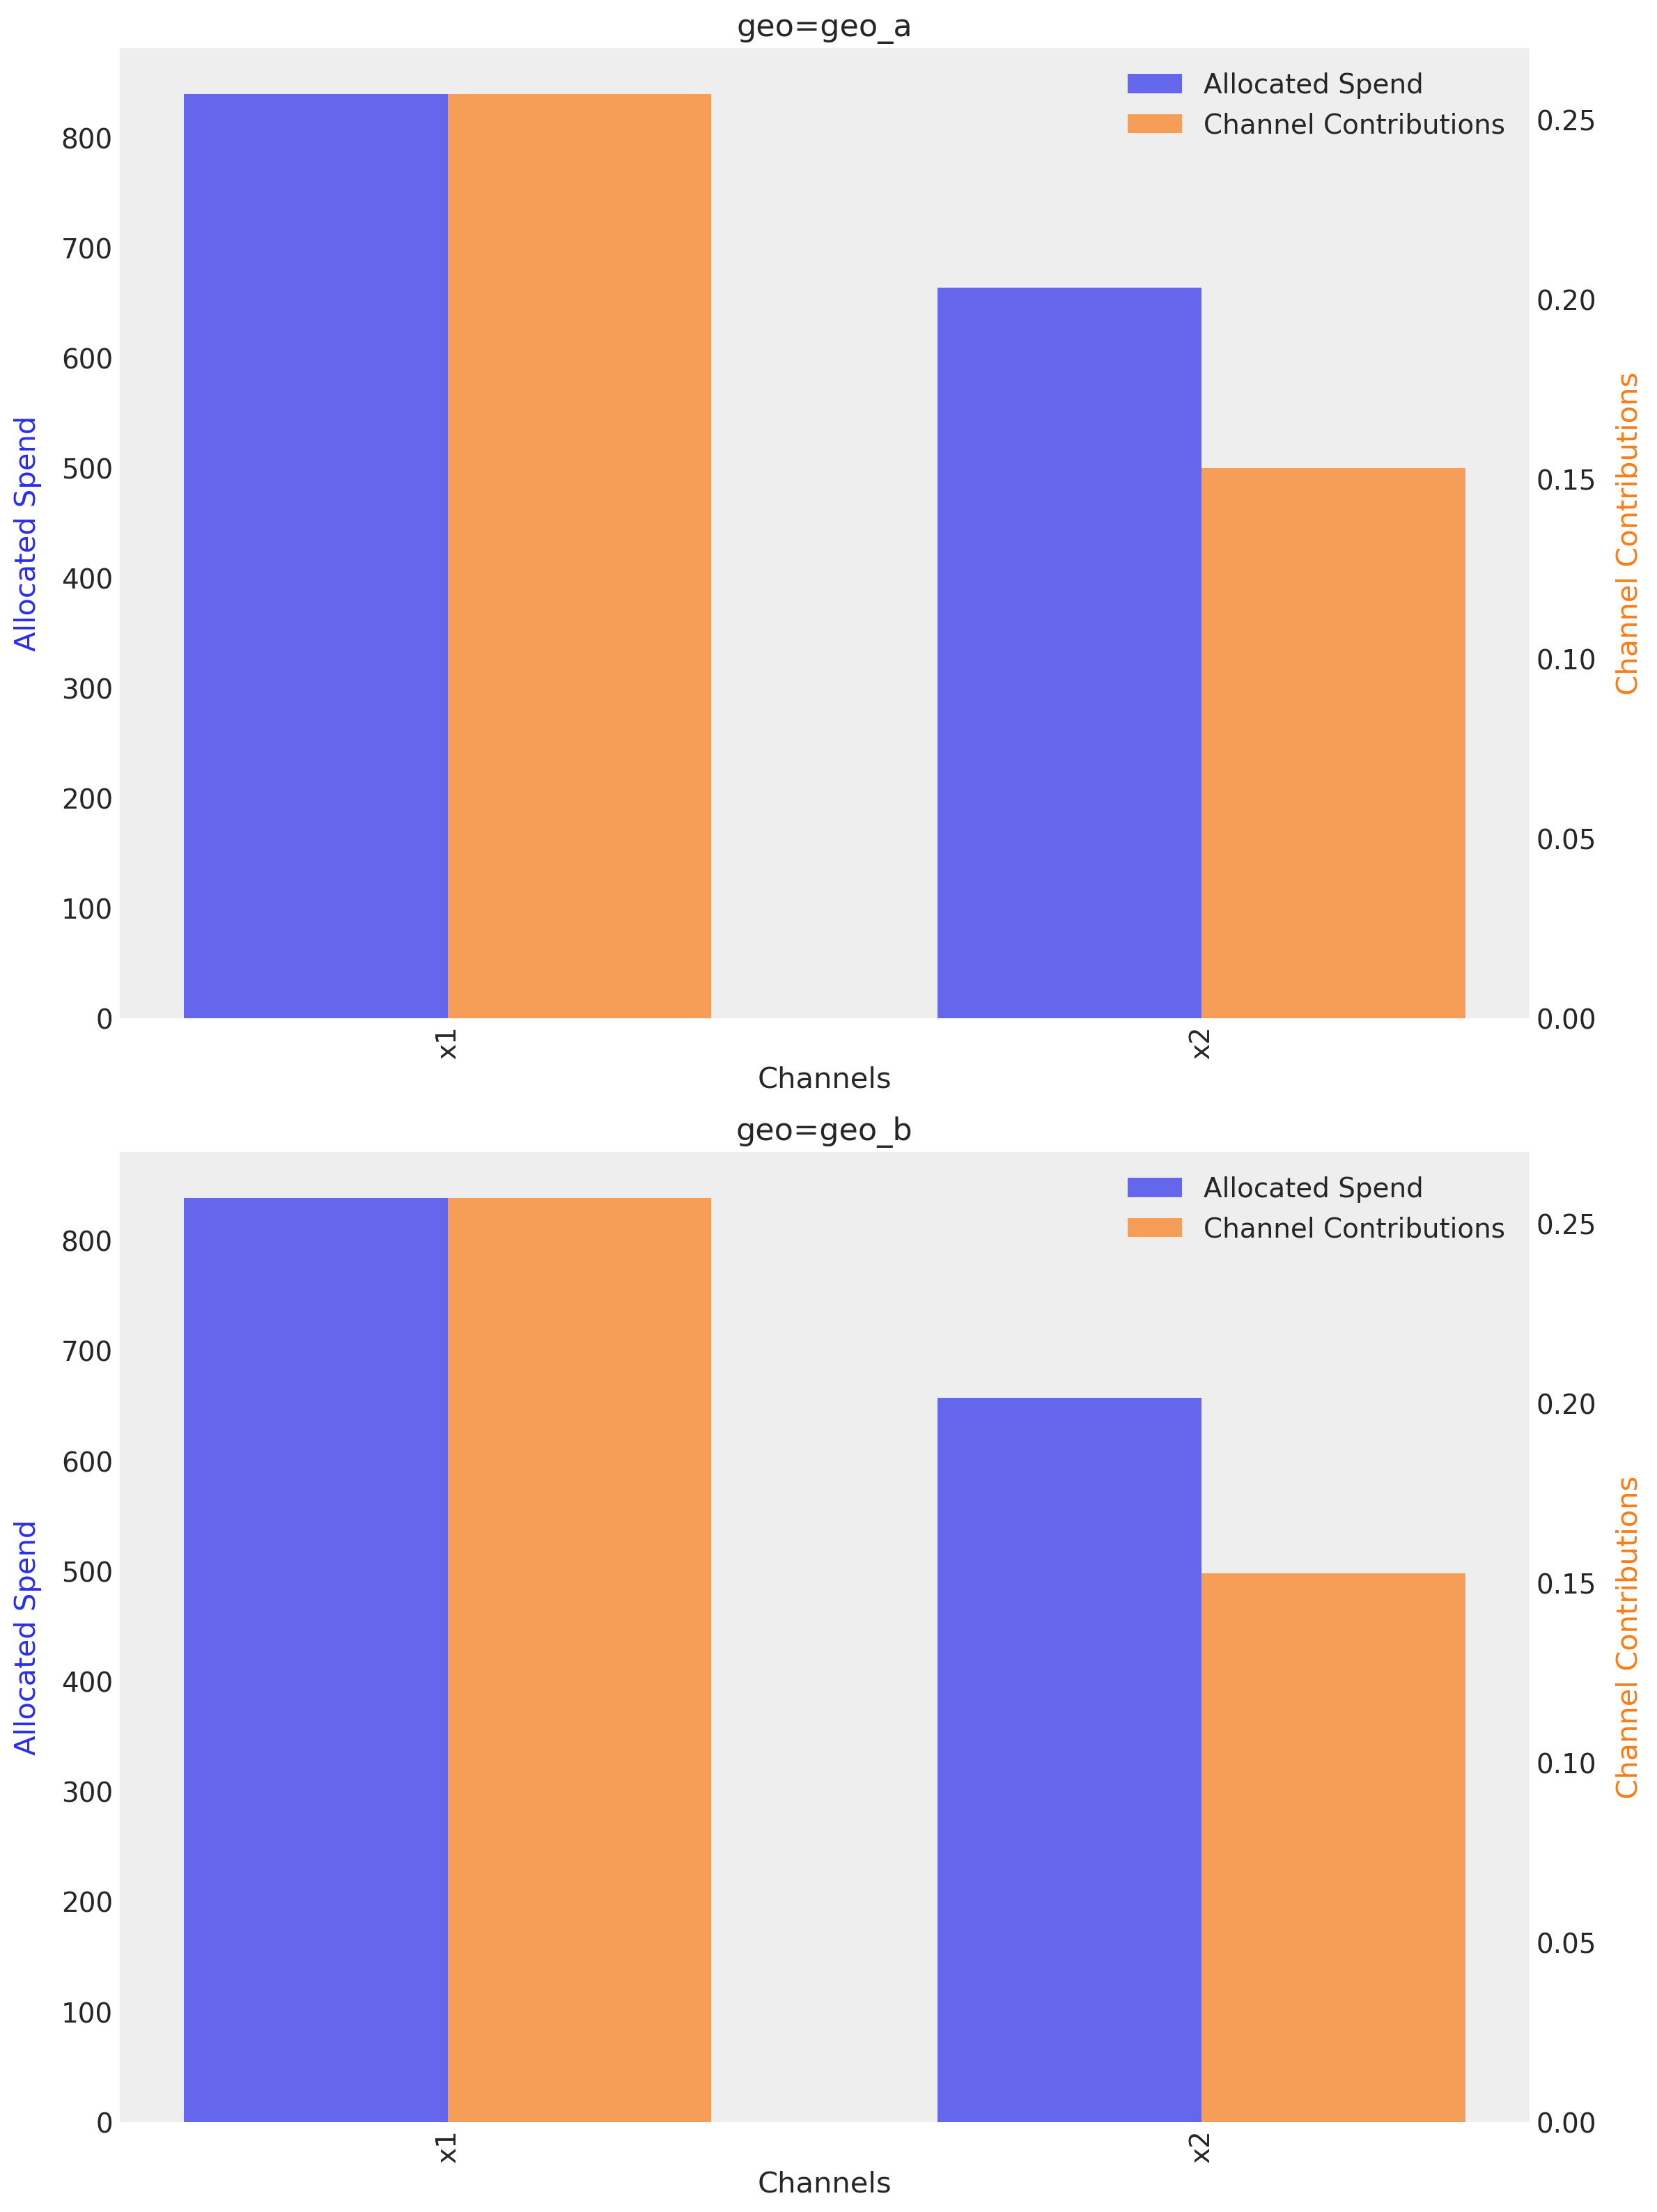

In [29]:
fig, ax = optimizable_model.plot.budget_allocation(
    samples=mts_diversification_posterior_response, figsize=(12, 8)
)

We can see that the optimizer is allocating the budget more evenly between the two channels ($X1$ and $X2$), they are spending almost the same amount. This allocation is more balanced than the previous ones. Nevertheless, the total allocated budget is more balanced, the risk is higher, in response terms.

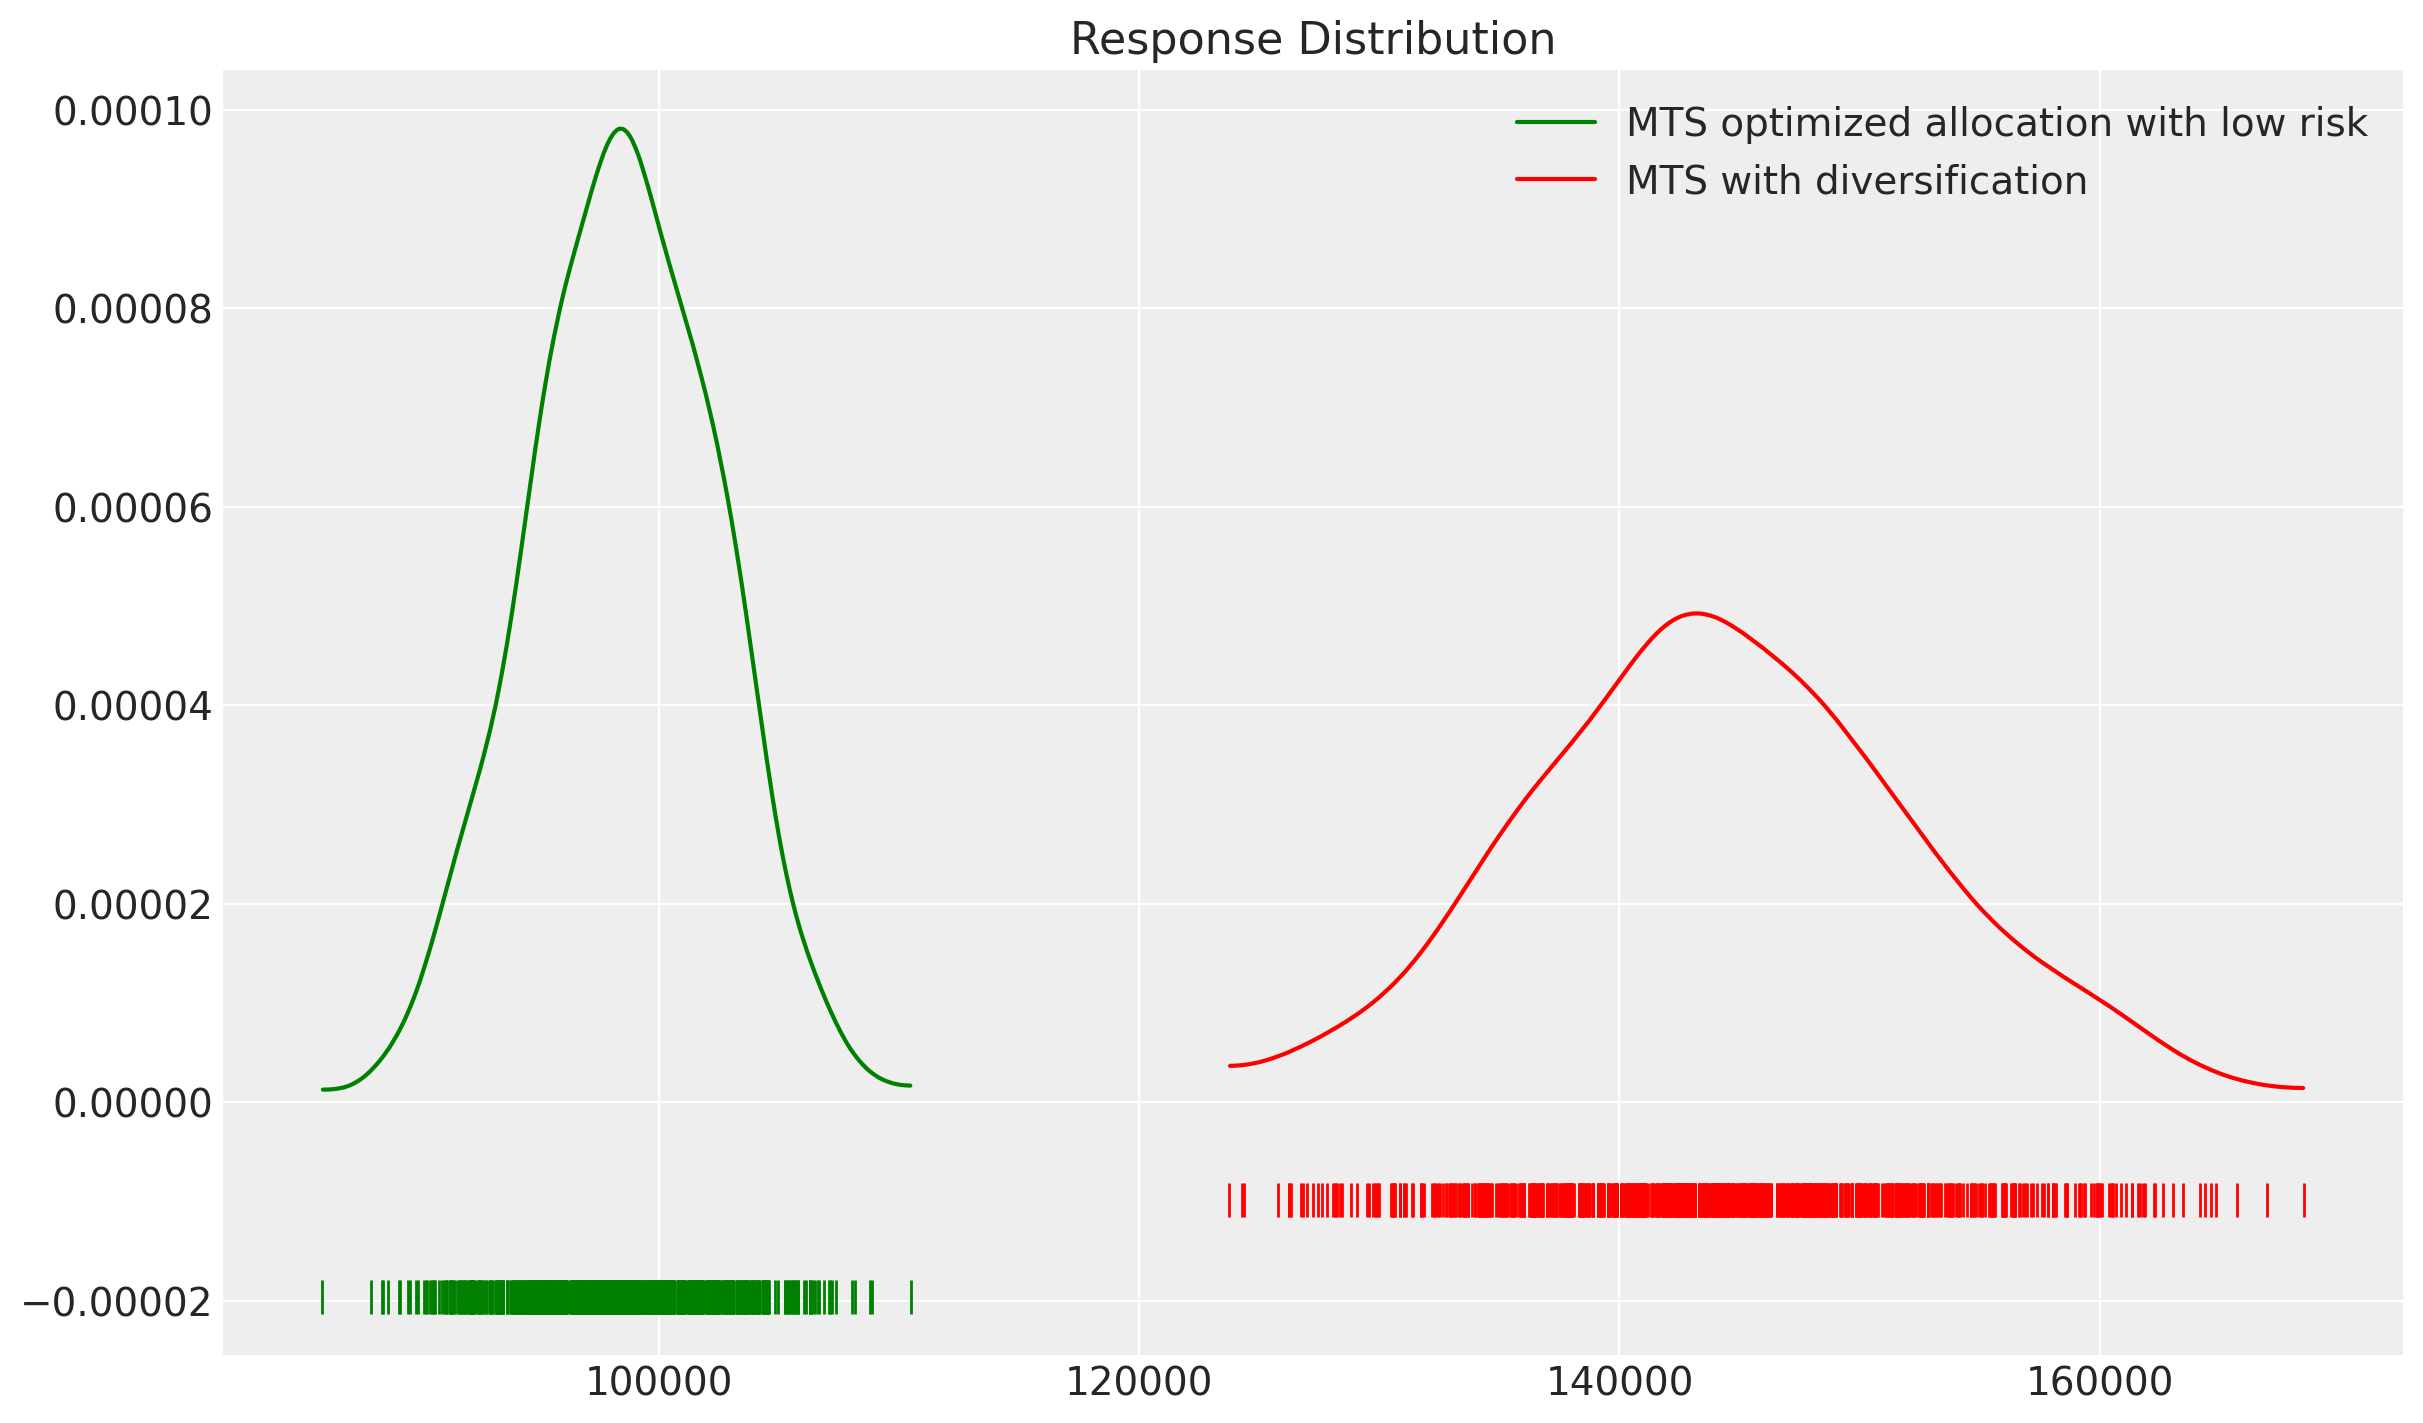

In [30]:
fig, ax = plt.subplots()
az.plot_dist(
    mts_posterior_response.total_media_contribution_original_scale.values,
    color="green",
    label="MTS optimized allocation with low risk",
    ax=ax,
    rug=True,
)
az.plot_dist(
    mts_diversification_posterior_response.total_media_contribution_original_scale.values,
    color="red",
    label="MTS with diversification",
    ax=ax,
    rug=True,
)
plt.title("Response Distribution");

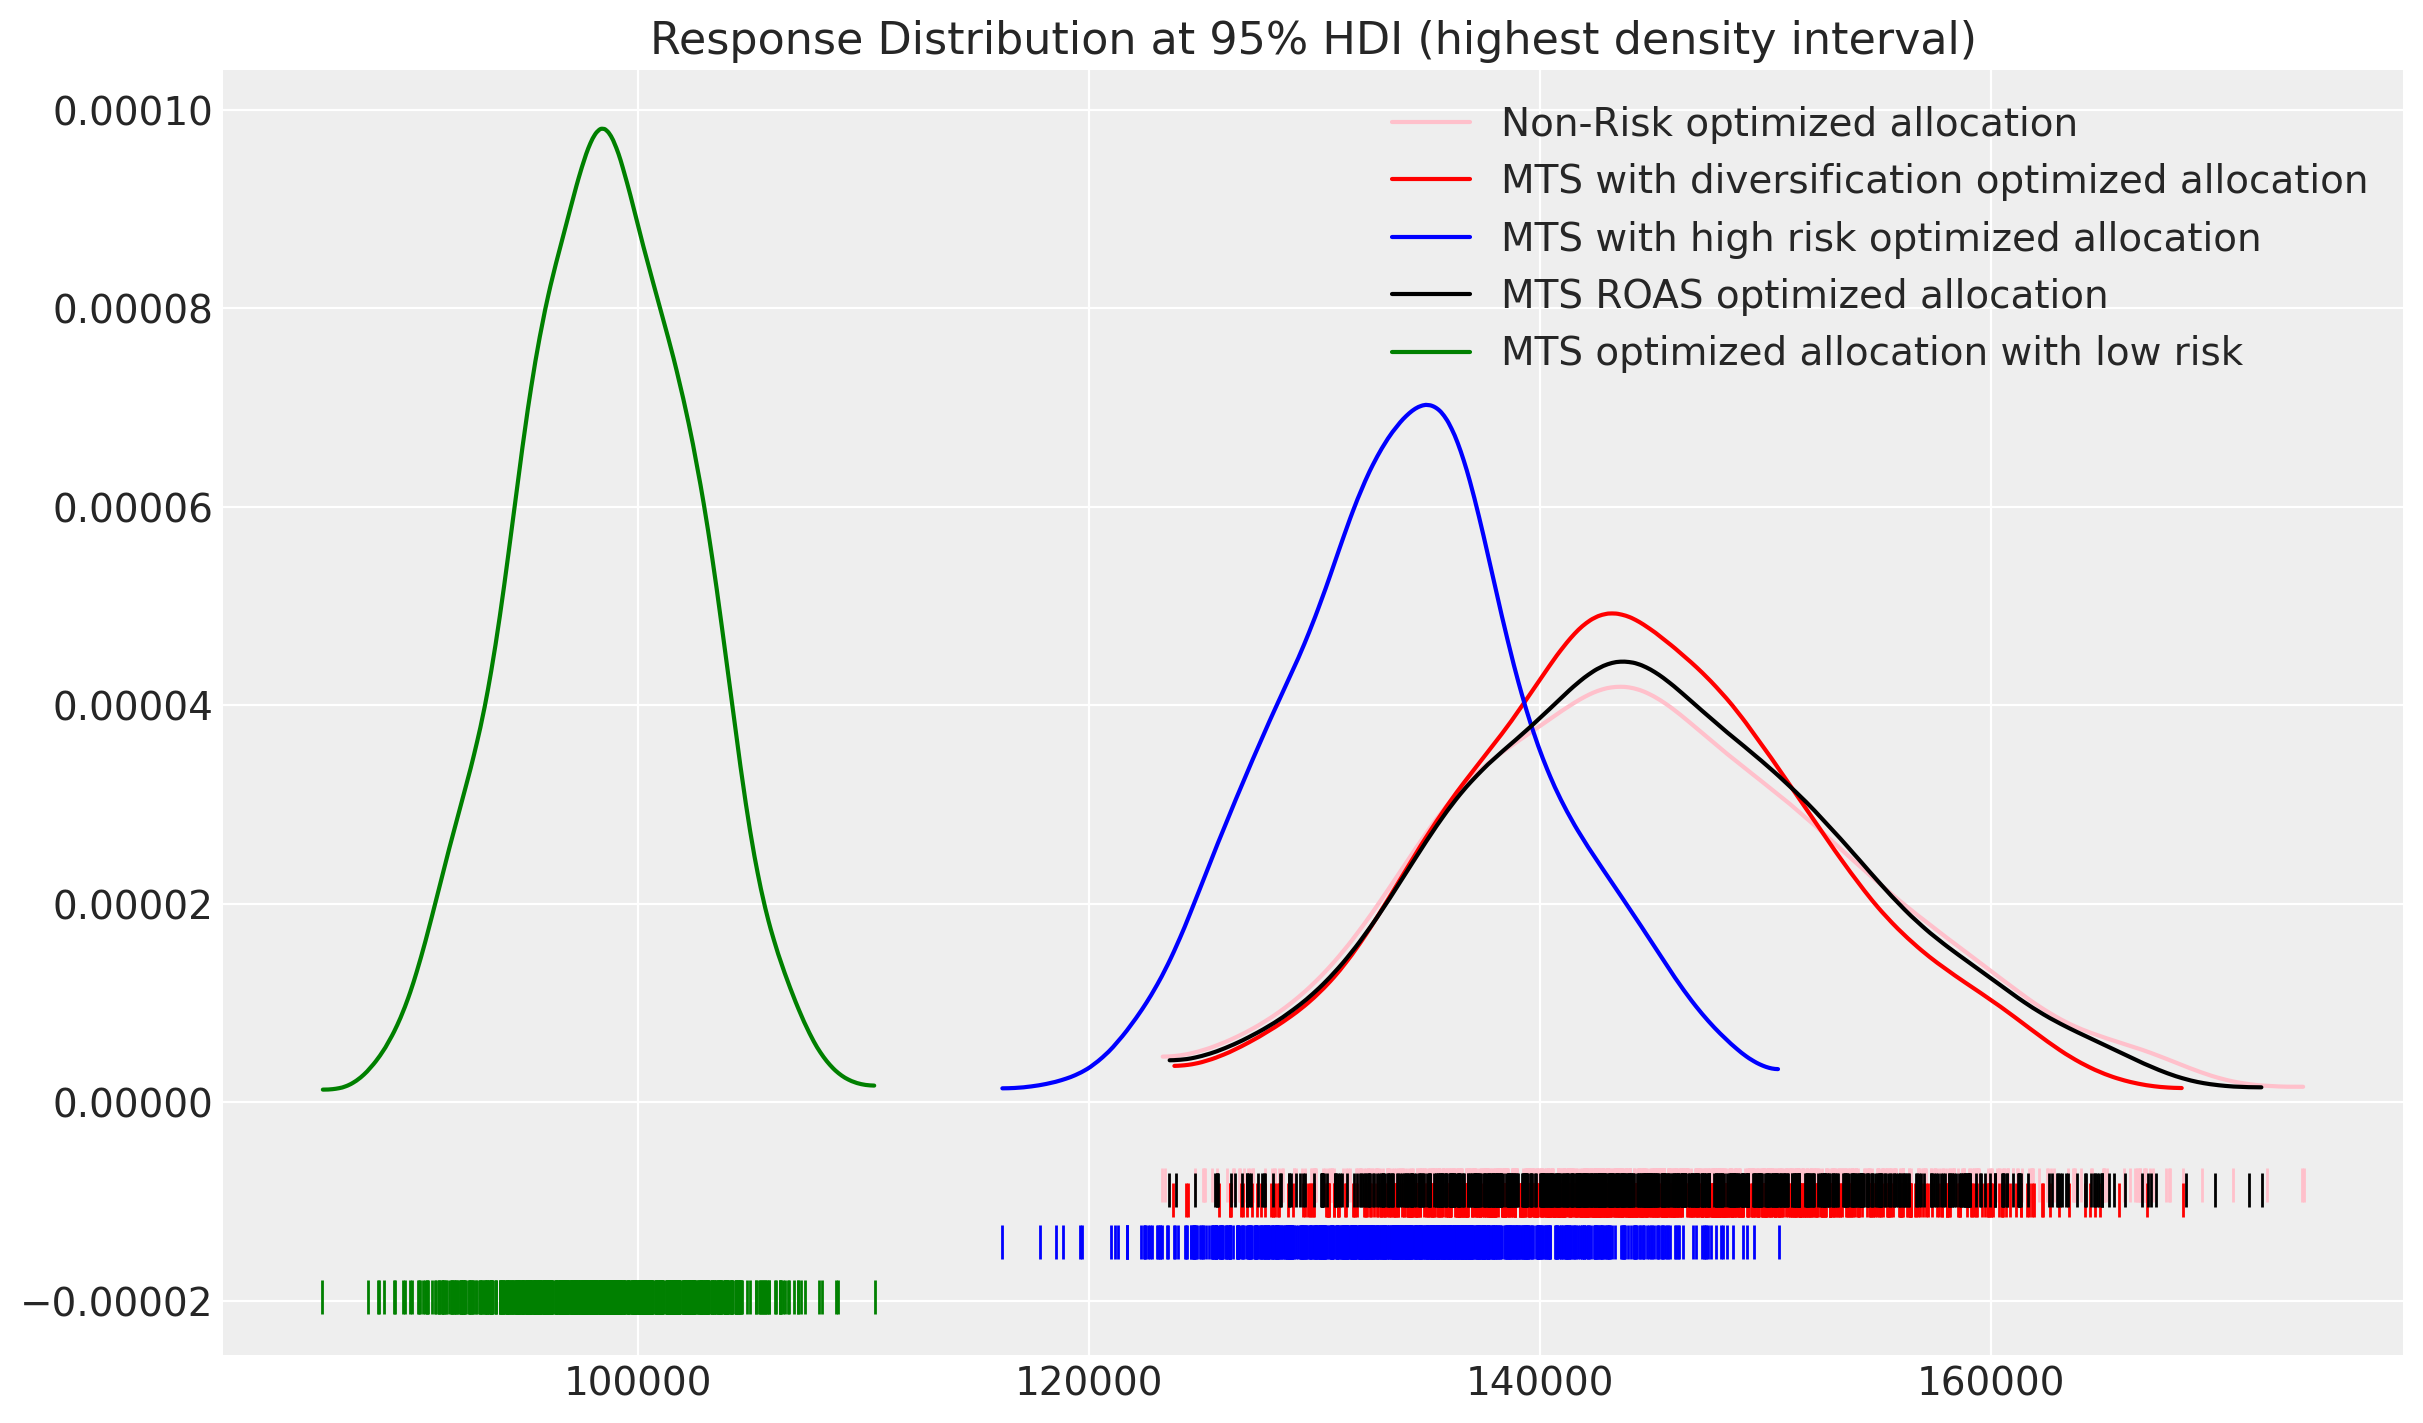

In [31]:
# Plot all the response distributions one next to each other in the same figure
fig, ax = plt.subplots(figsize=(12, 7))
# remove the descriptions in the plot of mean and interval
az.plot_dist(
    naive_posterior_response.total_media_contribution_original_scale.values,
    ax=ax,
    color="pink",
    label="Non-Risk optimized allocation",
    rug=True,
)
az.plot_dist(
    mts_diversification_posterior_response.total_media_contribution_original_scale.values,
    ax=ax,
    color="red",
    label="MTS with diversification optimized allocation",
    rug=True,
)
az.plot_dist(
    mts_posterior_response_high_risk.total_media_contribution_original_scale.values,
    ax=ax,
    color="blue",
    label="MTS with high risk optimized allocation",
    rug=True,
)
az.plot_dist(
    mts_roas_posterior_response.total_media_contribution_original_scale.values,
    ax=ax,
    color="black",
    label="MTS ROAS optimized allocation",
    rug=True,
)
az.plot_dist(
    mts_posterior_response.total_media_contribution_original_scale.values,
    ax=ax,
    color="green",
    label="MTS optimized allocation with low risk",
    rug=True,
)
ax.set_title("Response Distribution at 95% HDI (highest density interval)");

Great, here its clear how different strategies can lead to similar results, but with different risk profiles. Some distributions are more narrow, and some are more spread based on the risk tolerance.

## Conclusion  
In this notebook, we have examined the methodology for assessing the risk associated with various budget allocations, utilizing distinct strategies. We have also demonstrated how to generate an optimal budget allocation that aligns with a specified risk tolerance criterion. Three separate risk assessment metrics were employed: the Mean Tightness Score (MTS), Value at Risk (VaR), and a custom criterion that integrates both the mean tightness score and the diversification ratio.

## Next Steps  
It is essential to recognize that not all risk assessment criteria are compatible with the output without appropriate transformations. For instance, to compute the VaR, we analyzed the Return on Advertising Spend (ROAS) distribution; utilizing the response distribution directly would not adhere to the assumptions inherent in the VaR formula, potentially resulting in inconsistent or nonsensical outcomes.

The next step is for you to develop your own risk assessment criterion and apply it to optimize your budget allocation.

In [32]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sat Jul 26 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pytensor: 2.31.7

matplotlib    : 3.10.3
numpy         : 2.2.6
pymc_marketing: 0.15.1
pandas        : 2.3.1
arviz         : 0.22.0

Watermark: 2.5.0

